# Part 0: Learning Objectives and Setup

## What you will learn
- Part 1: Dynamical systems and "Maze" data
  - Neural data preprocessing
    - Binning
    - Smoothing
    - Aligning
  - Inspecting the data!
- Part 2: Training a deep auto-encoder
  - Building a neural network model
  - Loss functions
  - Training Loops
  - Evaluation Metrics
- Part 3: Training a sequential auto-encoder
  - Latent Factor Analysis via Dynamical Systems (LFADS)
  - Finding initial conditions
  - Recurrent Neural Networks (RNNs)
    - Linear RNNs
    - Gated Recurrent Units (GRUs)
  - Building your sequential auto-encoder
  - Latent trajectories in motor cortex!

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SaberaTalukder/Chen_Institute_DataSAI_for_Neuroscience/blob/main/07_13_22_day7_deep_learning_and_LFADS/code/solutions/solutions_latent_variable_models_LFADS.ipynb)

## Environment setup


Run this code to prepare the environment for this demonstration

In [26]:
## TODO: Run this once to set up your environment. Comment these out if you have to restart your notebook for speed.
# !pip3 install torch
# !pip3 install pytorch_lightning
# !pip3 install torchvision
# !pip3 install dandi
# !pip3 install git+https://github.com/neurallatents/nlb_tools.git
# !pip3 install cmasher

## Data download

Uncomment the line below to download the dataset into your colab notebook. We'll be using the dataset collected by Mark Churchland and first published in 2008 called the "Maze Dataset". It is publically available as part of the Neural Latents Benchmark contest (https://neurallatents.github.io/).

In [27]:
## This downloads the dataset that we will be using for this workshop
## Only needs to be run once
!dandi download DANDI:000140/0.220113.0408
!dandi download https://dandiarchive.org/dandiset/000138
!mv 000140 ../../data/
!mv 000138 ../../data/

PATH                                                              SIZE     DONE    DONE% CHECKSUM STATUS    MESSAGE    
dandiset.yaml                                                                                     skipped   no change  
sub-Jenkins/sub-Jenkins_ses-small_desc-test_ecephys.nwb                                                                
sub-Jenkins/sub-Jenkins_ses-small_desc-train_behavior+ecephys.nwb                                                      
Summary:                                                          0 Bytes  0 Bytes                1 skipped 1 no change
                                                                  +29.9 MB 0.00%                                       


ERROR: 2 asynchronous workers failed

Producing value for row ('sub-Jenkins/sub-Jenkins_ses-small_desc-test_ecephys.nwb',) failed:
Traceback (most recent call last):
  File "C:\Users\Chris\miniconda3\envs\chenEnv3\lib\site-packages\pyout\interface.py", line 279, in _print_async

2022-07-13 09:08:15,104 [ WARNING] A newer version (0.44.1) of dandi/dandi-cli is available. You are using 0.41.0
2022-07-13 09:08:18,074 [    INFO] Logs saved in C:\Users\Chris\AppData\Local\dandi\dandi-cli\Logs\20220713130814Z-13020.log


PATH                                                              SIZE      DONE    DONE% CHECKSUM STATUS    MESSAGE    
dandiset.yaml                                                                                      skipped   no change  
sub-Jenkins/sub-Jenkins_ses-large_desc-test_ecephys.nwb                                                                 
sub-Jenkins/sub-Jenkins_ses-large_desc-train_behavior+ecephys.nwb                                                       
Summary:                                                          0 Bytes   0 Bytes                1 skipped 1 no change
                                                                  +149.4 MB 0.00%                                       


ERROR: 2 asynchronous workers failed

Producing value for row ('sub-Jenkins/sub-Jenkins_ses-large_desc-test_ecephys.nwb',) failed:
Traceback (most recent call last):
  File "C:\Users\Chris\miniconda3\envs\chenEnv3\lib\site-packages\pyout\interface.py", line 279, in _print

2022-07-13 09:08:19,465 [ WARNING] A newer version (0.44.1) of dandi/dandi-cli is available. You are using 0.41.0
2022-07-13 09:08:21,849 [    INFO] Logs saved in C:\Users\Chris\AppData\Local\dandi\dandi-cli\Logs\20220713130818Z-14996.log



    return self.__get_result()
  File "C:\Users\Chris\miniconda3\envs\chenEnv3\lib\concurrent\futures\_base.py", line 391, in __get_result
    raise self._exception
  File "C:\Users\Chris\miniconda3\envs\chenEnv3\lib\concurrent\futures\thread.py", line 58, in run
    result = self.fn(*self.args, **self.kwargs)
  File "C:\Users\Chris\miniconda3\envs\chenEnv3\lib\site-packages\pyout\interface.py", line 482, in async_fn
    for i in gen:
  File "C:\Users\Chris\miniconda3\envs\chenEnv3\lib\site-packages\dandi\download.py", line 521, in _download_file
    raise FileExistsError(f"File {path!r} already exists")
FileExistsError: File '.\\000138\\sub-Jenkins\\sub-Jenkins_ses-large_desc-train_behavior+ecephys.nwb' already exists



mv: cannot move '000140' to '../../data/000140': Directory not empty
mv: cannot move '000138' to '../../data/000138': Directory not empty


## Imports and helper functions

Run this section once to get useful helper functions and imports. You shouldn't need to modify any of this code

In [95]:
## Generic imports and helper functions that we will use later in the notebook. Put here to reduce clutter.
# Imports
import os
import torch
from torchvision import datasets
from torchvision import transforms

from sklearn.linear_model import LinearRegression, PoissonRegressor
from nlb_tools.nwb_interface import NWBDataset
import h5py
import numpy as np
import pandas as pd
import logging
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import cmasher as cmr
logger = logging.getLogger(__name__)
from sklearn.decomposition import PCA
from torch.autograd import Variable
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d   
from scipy.stats import sem
from IPython import display


import random
random.seed(2022)

def smooth_gaussian(data, kernel_size):
    for i  in range(data.shape[1]):
        data[:,i] = gaussian_filter1d(data[:,i], kernel_size)
    return data
    
def plot_cond_avg_latent_traj(latents_plot, conds_trial, conds_to_plot, kernel_size, cond_avg = True):
    fig1 = plt.figure(figsize = (10,10))
    ax1 = fig1.add_subplot(111, projection="3d")
    latents_plot = smoothFiring(latents_plot, kernel_size = kernel_size, gaussian=True)
    pca = PCA(n_components=3)
    latents_pca = pca.fit_transform(latents_plot)
    latents_pca = np.reshape(latents_pca, (75, 140, 3))
    cmap = cmr.neon
    colors = cmap(np.linspace(0, 1, len(conds_to_plot)))
    for i, cond in enumerate(conds_to_plot):
        trials = np.squeeze(latents_pca[conds_trial == cond, :,:])
        n_trials = trials.shape[0]
        alpha = np.linspace(0.5, 1, n_trials)
        if not cond_avg:
            for j in range(n_trials):
                ax1.plot(trials[j,:,0], trials[j,:,1], trials[j,:,2], color =  colors[i,:], alpha = alpha[j])
        else:
            mean_trials = np.mean(trials, axis = 0)
            ax1.plot(mean_trials[:,0], mean_trials[:,1], mean_trials[:,2],color =  colors[i,:], label = f"cond {cond}")
    ax1.legend()
    ax1.set_title(f"Latent trajectories, color coded by condition")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")



def scatter_latents(latents_in):
    latents_all = latents_in
    pca = PCA(n_components=3)
    latents = pca.fit_transform(latents_all)

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, projection="3d")
    ax1.scatter(*latents.T)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
# Plot Latent trajectories

def plot_trials(trial_data, kernel_size, trial_nums, gaussian):
    fig, axes = plt.subplots(3, len(trial_nums),  figsize = (5*len(trial_nums),15))
    for i, trial_ind in enumerate(trial_nums):
        trial = trial_data[trial_data['trial_id'] == trial_ind]
        firing = np.float64(trial["spikes"][:].to_numpy())
        firing_smooth = smoothFiring(firing, kernel_size, gaussian= gaussian)
        ax1 = axes[0][i]
        ax1.imshow(firing_smooth.T,interpolation='nearest', aspect='auto')
        t = np.linspace(0,len(firing_smooth[:,1]), len(firing_smooth[:,1]))
        if i == 0:
            ax1.set_ylabel('Neurons')
        ax1.set_title(f"Trial: {trial_ind}")
        ax1.set_xlim((0, 150))
        ax2 = axes[1][i]
        ax2.plot(t,trial["hand_vel"]["x"],linewidth=3, label = "x_vel")
        ax2.plot(t,trial["hand_vel"]["y"],linewidth=3, label = "y_vel")
        ax2.set_xlim(0, 150)
        if i == 0:
            ax2.set_xlabel('Time Bins')
            ax2.set_ylabel("Hand Velocity (in x/y)")
            ax2.legend()

        ax3 = axes[2][i]
        ax3.plot(trial["hand_pos"]["x"], trial["hand_pos"]["y"],linewidth=3, color = 'k')
        ax3.set_xlim((-165, 165))
        ax3.set_ylim((-165, 165))
        if i == 0:
            ax3.set_xlabel('X Position')
            ax3.set_ylabel("Y Position")

def plot_FR_conds(trial_data, kernel_size, cond_list, neuron_list, gaussian):
    n_conds = len(cond_list)
    n_time = 140
    n_neurons = 107
    cmap = cmr.neon
    colors = cmap(np.linspace(0, 1, len(cond_list)))
    fig, axes = plt.subplots(nrows=len(neuron_list)+2, ncols= 1,figsize = (8,5*len(neuron_list)), sharex= True)

    mean_vel = np.zeros((n_time, 2, n_conds))
    mean_fr = np.zeros((n_time, 107, n_conds))

    std_vel = np.zeros((n_time, 2, n_conds))
    std_fr = np.zeros((n_time, 107, n_conds))
    for i, cond in enumerate(cond_list):
        trials = trial_data[trial_data.trial_cond == cond]
        grouped = list(trials.groupby('trial_id', sort=False))  
        vel = np.stack([trial['hand_vel'].to_numpy() for _, trial in grouped])
        fr = np.float64(np.stack([trial['spikes'].to_numpy() for _, trial in grouped]))
        n_trials = len(grouped)
        for j in range(n_trials):
            fr[j,:, :] =  np.squeeze(smoothFiring(fr[j,:,:], kernel_size=kernel_size, gaussian = gaussian))*200
        mean_vel[:,:,i] = np.mean(vel, axis = 0)
        std_vel[:,:,i] = sem(vel, axis = 0)
        mean_fr[:,:,i] = np.mean(fr, axis=0)
        std_fr[:,:,i] = sem(fr, axis=0)

    t = np.linspace(-250, 450, 140)
    axX = axes[0]
    axY = axes[1]

    for i in range(len(cond_list)):
        axX.plot(t, mean_vel[:,0,i],linewidth = 3, color = colors[i,:], label = f"Condition {cond_list[i]}")
        axY.plot(t, mean_vel[:,1,i],linewidth = 3, color = colors[i,:])
        axX.plot([0,0], [np.min(mean_vel[:,0]), np.max(mean_vel[:,0])],linewidth = 3,color ='k')
        axY.plot([0,0], [np.min(mean_vel[:,1]), np.max(mean_vel[:,1])],linewidth = 3,color ='k')

        axX.fill_between(
                    t,
                    mean_vel[:,0,i] - std_vel[:,0,i],
                    mean_vel[:,0,i] + std_vel[:,0,i],
                    color = colors[i,:],
                    alpha=0.2,
                )
        axY.fill_between(
                    t,
                    mean_vel[:,1,i] - std_vel[:,1,i],
                    mean_vel[:,1,i] + std_vel[:,1,i],
                    color = colors[i,:],
                    alpha=0.2,
                )
        axX.legend(loc = "upper left")

    axX.set_xlabel('Time (ms)')
    axX.set_ylabel("X Velocity (cm/s)")

    axY.set_xlabel('Time (ms)')
    axY.set_ylabel("Y Velocity (cm/s)")

    for i, n_ind in enumerate(neuron_list):
        ax = axes[i+2]
        for j in range(len(cond_list)):
            ax.plot(t, mean_fr[:,n_ind,j], linewidth = 3, color = colors[j,:])

            ax.fill_between(
                    t,
                    mean_fr[:,n_ind,j] - std_fr[:,n_ind,j],
                    mean_fr[:,n_ind,j] + std_fr[:,n_ind,j],
                    color = colors[j,:],
                    alpha=0.2,
                )
            a = 1
        ax.set_ylabel("Firing Rate (hz)")
        ax.set_title(f"Neuron {n_ind}")
        if i == len(neuron_list):
            ax.set_xlabel("Time (ms)")
def plot_ics(ics_numpy, cond_arr):
    fig2 = plt.figure(figsize = (10,10))
    ax2 = fig2.add_subplot(111, projection="3d")
    num_conds = len(np.unique(cond_arr))
    cmap = cmr.neon
    colors = cmap(np.linspace(0, 1, num_conds))
    pca = PCA(n_components=3)
    ic_pca = pca.fit_transform(ics_numpy)
    for i  in range(num_conds):
        ics_cond = ic_pca[cond_arr == i,:]
        ax2.scatter(ics_cond[:,0], ics_cond[:,1], ics_cond[:,2], color = colors[i,:])

    ax2.set_title(f"Initial conditions, color coded by condition")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")
      
def to_tensor(array):
    """Converts a loaded numpy array to a tensor
    and ensures correct dtype

    Parameters
    ----------
    array : np.array
        The numpy array to convert.

    Returns
    -------
    torch.Tensor
        The converted tensor.
    """
    return torch.tensor(array, dtype=torch.float)
    
def plot_smoothed_latent_trajs(latents_plot, num_trials, kernel_size):
    cmap = cmr.rainforest
    colors = cmap(np.linspace(0, 1, num_trials))
    fig2 = plt.figure(figsize = (10,10))
    ax2 = fig2.add_subplot(111, projection="3d")
    fig3 = plt.figure(figsize = (10,10))
    ax3 = fig3.add_subplot(111)
    n_trials, n_steps, n_latents = latents_plot.shape
    pca = PCA(n_components=3)
    latents_flat = latents_plot.reshape(-1, n_latents)
    latents_plot = pca.fit_transform(latents_flat)
    latents_plot = latents_plot.reshape(n_trials, n_steps, 3)
    t = np.linspace(0, n_steps, n_steps)
    explained_variance = np.sum(pca.explained_variance_ratio_)
    latents_smooth = np.zeros_like(latents_plot)
    for i in range(num_trials):
        latents_trial = np.float64(np.squeeze(latents_plot[i,:,:]))
        latents_trial = smoothFiring(latents_trial, kernel_size, gaussian=True)
        latents_smooth[i,:,:] = latents_trial
        ax2.plot(latents_trial[:, 0], latents_trial[:,1], latents_trial[:,2], color = colors[i,:])
        ax3 = fig3.add_subplot(num_trials, 1, i+1)
        ax3.plot(t, latents_trial[:,0], color = 'r')
        ax3.plot(t, latents_trial[:,1], color = 'g')
        ax3.plot(t, latents_trial[:,2], color = 'b')

def plot_pred_FR(pred_rates_plot, rates_plot, num_trials, kernel_size):
    cmap = cmr.rainforest
    colors = cmap(np.linspace(0, 1, num_trials))
    fig, axes = plt.subplots(1, num_trials,  figsize = (10*num_trials,15))
    n_trials, n_steps, n_neurons = rates.shape

    t = np.linspace(-250, 350, n_steps)
    rates_smooth = np.zeros_like(rates_plot)
    pred_rates_smooth = np.zeros_like(pred_rates_plot)
    for i in range(num_trials):
        ax1 = axes[i]
        rates_trial = np.squeeze(rates_plot[i,:,:])
        rates_trial = smoothFiring(rates_trial, kernel_size, gaussian=True)
        rates_smooth[i,:,:] = rates_trial
        pred_rates_trial = np.squeeze(pred_rates_plot[i,:,:])
        pred_rates_trial = smoothFiring(pred_rates_trial, kernel_size, gaussian=True)
        ax1.plot(t, rates_trial[:,0]*200, color = 'r')
        ax1.plot(t, rates_trial[:,1]*200, color = 'g')
        ax1.plot(t, rates_trial[:,2]*200, color = 'b')
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Firing rate (hz)')
    ax1.set_title("Predicted FR over time")

def add_conds_to_trial_data(trial_data_in, dataset_in):
    cond_fields = ['trial_type', 'trial_version']
    combinations = sorted(dataset_in.trial_info[cond_fields].dropna().set_index(cond_fields).index.unique().tolist())
    combinations = np.array(combinations)
    trial_data = trial_data_in.copy()
    trial_info = dataset_in.trial_info
    trial_nums = trial_info.trial_id.values
    trial_data['trial_cond'] = np.zeros(len(trial_data))
    for i,comb in enumerate(combinations):
        # Need a list of all the trial_ids that match cond
        flag1 = trial_info.trial_type.values == comb[0]
        flag2 = trial_info.trial_version.values == comb[1]
        flag3 = np.logical_and(flag1, flag2)
        trial_flag =np.where(flag3) # a list of indices in trial_info that
        cond_trials = trial_nums[trial_flag]
        trial_data.loc[np.isin(trial_data.trial_id, cond_trials),'trial_cond'] = i
    return trial_data


def plotPredictedFR(predFR, spiking, unitNum, kernel_size, window):
    fig1 = plt.figure(figsize = (10,10))
    ax1 = fig1.add_subplot(111)
    n_data,n_units = predFR.shape
    smoothSpiking = smoothFiring(spiking, kernel_size)
    smoothPred = smoothFiring(predFR, kernel_size=kernel_size)
    t = np.linspace(0, 5*n_data/1000, n_data)
    ax1.plot(t[window[0]:window[1]], smoothPred[window[0]:window[1], unitNum]*200, label = "predicted")
    ax1.plot(t[window[0]:window[1]], smoothSpiking[window[0]:window[1], unitNum]*200, label = "True")
    ax1.set_title(f"Neuron: {unitNum}")
    ax1.legend()
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Firing Rate (hz)")

def simulate_system(A, n_inits, n_steps):
    print(A)
    inits = np.random.rand(n_inits,2)-0.5
    states = np.zeros((n_inits, n_steps, 2))
    for i in range(n_inits):
        state = inits[i,:]
        for j in range(n_steps):
            states[i,j,:] = state
            state = np.matmul(A, state)
    
    fig1 = plt.figure(figsize = (10,10))
    ax1 = fig1.add_subplot(111)
    for i in range(n_inits):
        ax1.plot(states[i,:,0], states[i,:,1], color = 'k', linewidth = 0.5)
        ax1.scatter(states[i,0,0], states[i,0,1], color = 'g')
        ax1.scatter(states[i,-1,0], states[i,-1,1], color = 'r')
    ax1.set_title(f"Simulated 2D System")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")

def simulate_3D_system(A, init_state, n_steps):
    print(A)
    states = np.zeros((n_steps, 3))
    state = init_state
    for j in range(n_steps):
        states[j,:] = state
        state = np.matmul(A, state)

    fig1 = plt.figure(figsize = (10,10))
    ax1 = fig1.add_subplot(111, projection = "3d")

    ax1.plot(states[:,0], states[:,1], states[:,2], color = 'k', linewidth = 0.5)
    ax1.scatter(states[0,0], states[0,1], states[0,2], color = 'g')
    ax1.scatter(states[-1,0], states[-1,1], states[-1,2], color = 'r')    
    ax1.set_xlim([0,1])
    ax1.set_ylim([0,1])
    ax1.set_zlim([0,1])
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    ax1.set_title("Three Neuron Dynamics")
    ax1.view_init(30, 30)        
    
def computeHandVelR2(model, ds_array_train, kernel_size_in, gaussian = True):
    pred_rates_flat, latents_all = model(ds_array_train[0])

    # Get the data into Numpy arrays
    pred_rates_flat2 = torch.clone(pred_rates_flat)
    pred_rates_flat2 = pred_rates_flat2.detach().numpy()
    latents_all2 = torch.clone(latents_all)
    latents_all2 = latents_all2.detach().numpy()
    rates2 = torch.clone(ds_array_train[0])
    rates2 = rates2.detach().numpy()
    vel = ds_array_train[2]
    vel2 = torch.clone(vel)
    vel2 = vel2.detach().numpy()

    # Reshape the data into a trialized format to eliminate smoothing artifacts
    latents_all2 = np.reshape(latents_all2, (75, 140, 20))
    pred_rates2 = np.reshape(pred_rates_flat2, (75, 140, 142))
    rates2 = np.reshape(rates2, (75, 140, 107))

    # Initialize some variables for smoothing and our model fits
    n_trials, n_bins,  n_latents = latents_all2.shape
    latents_smooth = np.zeros((n_trials, n_bins, n_latents))
    rates_smooth = np.zeros((n_trials, n_bins, 107))
    pred_rates_smooth = np.zeros((n_trials, n_bins, 142))

    r2LatentHeldout= np.zeros(35)
    r2InputHeldout = np.zeros(35)
    r2PredHeldout = np.zeros(35)

    # Smooth our data with the specified smoothing window (using gaussian by default here)
    for i in range(latents_all2.shape[0]):
        latents_smooth[i,:,:] = smoothFiring(np.squeeze(latents_all2[i,:,:]), kernel_size_in, gaussian= gaussian)
        rates_smooth[i,:,:] = smoothFiring(np.squeeze(rates2[i,:,:]), kernel_size_in, gaussian= gaussian)
        pred_rates_smooth[i,:,:] = smoothFiring(np.squeeze(pred_rates2[i,:,:]), kernel_size_in, gaussian= gaussian)

    # Reshape our data into 2D arrays for linear regression
    latents_fit = latents_smooth.reshape((-1, n_latents))
    rates_fit = rates_smooth.reshape((-1, 107))
    pred_rates_fit = pred_rates_smooth.reshape((-1, 142))
    pred_rates_fit = pred_rates_fit[:,:107]

    # Fit a linear model to our heldout neurons from latents, input neurons, and decoded neurons
    for i in range(34):
        regLatent = PoissonRegressor().fit(latents_fit, pred_rates_flat2[:,108+i])
        r2LatentHeldout[i] = regLatent.score(latents_fit, pred_rates_flat2[:, 108+i])

        regInput = PoissonRegressor().fit(rates_fit, pred_rates_flat2[:,108+i])
        r2InputHeldout[i] = regInput.score(rates_fit, pred_rates_flat2[:, 108+i])

        regPred = PoissonRegressor().fit(pred_rates_fit, pred_rates_flat2[:,108+i])
        r2PredHeldout[i] = regPred.score(pred_rates_fit, pred_rates_flat2[:, 108+i])

    # Fit linear regression model from latents, input, and decoded neural activity to hand velocity
    regX = LinearRegression().fit(latents_fit, vel2[:,0])
    regY = LinearRegression().fit(latents_fit, vel2[:,1])

    regRatesX = LinearRegression().fit(rates_fit, vel2[:,0])
    regRatesY = LinearRegression().fit(rates_fit, vel2[:,1])

    regPredRatesX = LinearRegression().fit(pred_rates_fit, vel2[:,0])
    regPredRatesY = LinearRegression().fit(pred_rates_fit, vel2[:,1])    

    r2X =  regX.score(latents_fit, vel2[:,0])
    r2Y =  regY.score(latents_fit, vel2[:,1])

    r2rateX = regRatesX.score(rates_fit, vel2[:,0])
    r2rateY = regRatesY.score(rates_fit, vel2[:,1])

    r2PredRateX = regPredRatesX.score(pred_rates_fit, vel2[:,0])
    r2PredRateY = regPredRatesY.score(pred_rates_fit, vel2[:,1])


    print(f"R2 of X vel decoding from neurons: {r2rateX}")
    print(f"R2 of X vel decoding from latents: {r2X}")
    print(f"R2 of X vel decoding from autoencoded neurons: {r2PredRateX}\n")

    print(f"R2 of Y vel decoding from neurons: {r2rateY}")
    print(f"R2 of Y vel decoding from latents: {r2Y}")
    print(f"R2 of Y vel decoding from autoencoded neurons: {r2PredRateY}\n")

       
def computeHandVelR2Tensor(model, ds_tensor_train, kernel_size_in, gaussian = True):
    pred_rates, latents_all = model(ds_tensor_train[0])

    # Get the data into Numpy arrays
    pred_rates2 = torch.clone(pred_rates)
    pred_rates2 = pred_rates2.detach().numpy()
    latents_all2 = torch.clone(latents_all)
    latents_all2 = latents_all2.detach().numpy()
    rates2 = torch.clone(ds_tensor_train[1])
    rates2 = rates2.detach().numpy()
    vel = ds_tensor_train[2]
    vel2 = torch.clone(vel)
    vel2 = vel2.detach().numpy()

    # Initialize some variables for smoothing and our model fits
    n_trials, n_bins_in, n_heldin = rates2.shape
    n_trials, n_bins_fwd,  n_latents = latents_all2.shape
    latents_smooth = np.zeros((n_trials, n_bins_fwd, n_latents))
    rates_smooth = np.zeros((n_trials, n_bins_in, 142))
    pred_rates_smooth = np.zeros((n_trials, n_bins_fwd, 142))

    heldout = ds_tensor_train[1]
    heldout2 = torch.clone(heldout)
    heldout2 = heldout2.detach().numpy()

    r2LatentHeldout= np.zeros(35)
    r2InputHeldout = np.zeros(35)
    r2PredHeldout = np.zeros(35)
    # Smooth our data with the specified smoothing window (using gaussian by default here)
    for i in range(latents_all2.shape[0]):
        latents_smooth[i,:,:] = smoothFiring(np.squeeze(latents_all2[i,:,:]), kernel_size_in, gaussian= gaussian)
        rates_smooth[i,:,:] = smoothFiring(np.squeeze(rates2[i,:,:]), kernel_size_in, gaussian= gaussian)
        pred_rates_smooth[i,:,:] = smoothFiring(np.squeeze(pred_rates2[i,:,:]), kernel_size_in, gaussian= gaussian)

    # Reshape our data into 2D arrays for linear regression
    latents_fit = latents_smooth.reshape((-1, n_latents))
    rates_fit = rates_smooth.reshape((-1, 142))
    rates_fit = rates_fit[:,:107]
    pred_rates_fit = pred_rates_smooth.reshape((-1, 142))
    pred_rates_fit = pred_rates_fit[:,:107]
    heldout_fit = heldout2.reshape((-1, 142))

    # Fit a linear model to our heldout neurons from latents, input neurons, and decoded neurons
    for i in range(34):
        regLatent = PoissonRegressor().fit(latents_fit, heldout_fit[:,108+i])
        r2LatentHeldout[i] = regLatent.score(latents_fit, heldout_fit[:, 108+i])

        regInput = PoissonRegressor().fit(rates_fit, heldout_fit[:,108+i])
        r2InputHeldout[i] = regInput.score(rates_fit, heldout_fit[:, 108+i])

        regPred = PoissonRegressor().fit(pred_rates_fit, heldout_fit[:,108+i])
        r2PredHeldout[i] = regPred.score(pred_rates_fit, heldout_fit[:, 108+i])

    latents_fit2 = latents_smooth[:, :140,:]
    latents_fit2 = latents_fit2.reshape(-1, n_latents)
    # Fit linear regression model from latents, input, and decoded neural activity to hand velocity

    vel2 = vel2.reshape(-1,2)

    rates_fit2 = rates_smooth[:,:140, :107]
    rates_fit2 =rates_fit2.reshape((-1, 107))

    pred_rates_fit2 = pred_rates_smooth[:,:140,:107]
    pred_rates_fit2 = pred_rates_fit2.reshape((-1, 107))
    regX = LinearRegression().fit(latents_fit2, vel2[:,0])
    regY = LinearRegression().fit(latents_fit2, vel2[:,1])

    regRatesX = LinearRegression().fit(rates_fit2, vel2[:,0])
    regRatesY = LinearRegression().fit(rates_fit2, vel2[:,1])

    regPredRatesX = LinearRegression().fit(pred_rates_fit2, vel2[:,0])
    regPredRatesY = LinearRegression().fit(pred_rates_fit2, vel2[:,1])    

    r2X =  regX.score(latents_fit2, vel2[:,0])
    r2Y =  regY.score(latents_fit2, vel2[:,1])

    r2rateX = regRatesX.score(rates_fit2, vel2[:,0])
    r2rateY = regRatesY.score(rates_fit2, vel2[:,1])

    r2PredRateX = regPredRatesX.score(pred_rates_fit2, vel2[:,0])
    r2PredRateY = regPredRatesY.score(pred_rates_fit2, vel2[:,1])


    print(f"R2 of X vel decoding from neurons: {r2rateX}")
    print(f"R2 of X vel decoding from latents: {r2X}")
    print(f"R2 of X vel decoding from autoencoded neurons: {r2PredRateX}\n")

    print(f"R2 of Y vel decoding from neurons: {r2rateY}")
    print(f"R2 of Y vel decoding from latents: {r2Y}")
    print(f"R2 of Y vel decoding from autoencoded neurons: {r2PredRateY}\n")

def plot_cond_avg_pred_fr(pred_rates, conds_trial, conds_to_plot, units_to_plot, kernel_size, cond_avg = True):
    if len(pred_rates.shape) <3:
        rates_plot = smoothFiring(pred_rates, kernel_size = kernel_size, gaussian=True)
        rates_plot = np.reshape(rates_plot, (75, 140, 142))
    else:
        rates_plot = pred_rates[:,:140,:]
    fig1, axes = plt.subplots(len(units_to_plot),1, figsize =  (8,6*len(units_to_plot)))


    cmap = cmr.neon
    colors = cmap(np.linspace(0, 1, len(conds_to_plot)))
    t = np.linspace(-250, 350, 140)
    for unit_num, unit in enumerate(units_to_plot):
        ax1 = axes[unit_num]
        for i, cond in enumerate(conds_to_plot):
            trials = np.squeeze(rates_plot[conds_trial == cond, :,unit_num])
            n_trials = trials.shape[0]
            alpha = np.linspace(0.5, 1, n_trials)
            if not cond_avg:
                for j in range(n_trials):
                    ax1.plot(t, trials[j,:]*200, color =  colors[i,:], alpha = alpha[j])
            else:
                mean_trials = np.mean(trials, axis = 0)
                ax1.plot(t, mean_trials*200, color =  colors[i,:], label = f"cond {cond}")
        if unit_num == 0:
            ax1.legend()
        ax1.set_title(f"Neuron {unit}")
        ax1.set_xlabel("Time (ms)")
        ax1.set_ylabel("Firing Rate (hz)")

# Part 1: Neural Dynamics and Maze Data

## What are neural dynamics?

Neurons are cells that are connected together in a network. They communicate using action potentials, electrical impulses that transmit information across synapses.

Consider a set of three neurons that are wired together with a very specific arrangement, depicted below.


![title](../../images/Dyn1.png)

There are three things to take away from this diagram
 1. The "state" of this network is defined as the vector of the neurons' instantaneous firing rates
 2. The state develops as a function of the current activity
 3. The strength of the three synapses determines how the state will develop

These three points can be summarized in three equations, which I provide below.

![title](../../images/Dyn2.png)

Take a minute (without running the next cell!) to think about what the activity of this network would look like if the network were to have an initial firing rate of $N_{0}$ = [1,0,0].

Draw a 3D plot of how the state would evolve over time. X, Y, and Z should correspond to the x,y, and z axes.

![title](../../images/Dyn3.png)

Interestingly, if we were to record from this simple neural circuit, we would find that despite the system having 3 neurons (i.e., a 3 dimensional system), the neural activity produced from these initial conditions only has two dimensions.

No matter how long you run this circuit forwards in time, the activity will never leave this 2D plane in the 3D neural space.

This lower dimensional representation of dynamics can be called the circuit's **Latent Dynamics**

![title](../../images/Dyn4.png)

This simple example captures all of the principles that I would like you to take away from the workshop today:
- Neural dynamics describe how neural activity develops over time.
- These dynamics arise (at least in part) from how the neurons in a network are connected to one another
- These dynamics often fall on a lower-dimensional space than the number of neurons in the network.
  - These are often called "latent" dynamics
- We can use mathematical models to capture these latent dynamics

Now we're going to dig into the data we are going to use to explore latent dynamics!

## Overview of Maze Dataset

This dataset was collected from primary motor cortex (M1) and dorsal premotor cortex (PMd). A basic description can be found in the blurb on the NLB datasets page: https://neurallatents.github.io/datasets

    The maze task is a delayed center-out reach task with barriers, resulting in a variety of straight and curved trajectories. Neural activity was recorded from the dorsal premotor and primary motor cortices, and cursor, monkey gaze position, and monkey hand position and velocity are also provided.

    It has been found that M1/PMd activity during such planned, highly-stereotyped movements is predictable from neural population state at movement onset. Though this does not imply the neural system is itself autonomous, predictability makes the dataset useful for evaluating a method’s ability to model autonomous dynamics. In addition to a standard session, we provide 3 recording sessions (standard, large, medium, and small) with varying numbers of trials in order to test how modeling methods scale to limited data.

    The 4 recording sessions we are releasing are provided by Matt Kaufman, Mark Churchland, and Krishna Shenoy at Stanford University.
We will be using the "small" version for ease of computational resources

![title](../../images/maze_fig1.png)

First things first: We want to deal with the data in a manageable bin size: Currently it is binned a 1 ms bin widths, which means that the vast majority of bins have no spikes in them. We're going to move to a larger bin size (5 ms) for convenience. This will let us train models more quickly and more easily inspect the firing rates.

In [29]:
## Get the current path and pull the dataset into the Neurodata Without Borders format
curr_path = os.getcwd()
fpath = "../../data/000140/sub-Jenkins/"
os.listdir(fpath) 

dataset = NWBDataset(fpath=fpath) 

## Resample the dataset to 20 ms bin size
print(f'Data shape: {dataset.data.shape}')
print(f'Bin width: {dataset.bin_width} ms')
dataset.resample(5)
print(f'Resampled data shape: {dataset.data.shape}')
print(f'Resampled bin width: {dataset.bin_width} ms')

c:\Users\Chris\miniconda3\envs\chenEnv3\lib\site-packages\hdmf\utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Data shape: (373666, 150)
Bin width: 1 ms
Resampled data shape: (74734, 150)
Resampled bin width: 5 ms


## Inspecting the Maze dataset
Now we're going to look at the dataset and see what it's components are. We'll start with one field, the "trial_info".

In [30]:
## Inspect the fields available to you
print(dataset.trial_info.keys())
dataset.trial_info["split"]
dataset.trial_info

Index(['trial_id', 'start_time', 'end_time', 'move_onset_time', 'split',
       'trial_type', 'trial_version', 'maze_id', 'success', 'target_on_time',
       'go_cue_time', 'rt', 'delay', 'num_targets', 'target_pos',
       'num_barriers', 'barrier_pos', 'active_target'],
      dtype='object')


,trial_id,start_time,end_time,move_onset_time,split,trial_type,trial_version,maze_id,success,target_on_time,go_cue_time,rt,delay,num_targets,target_pos,num_barriers,barrier_pos,active_target
0,0,0 days 00:00:00,0 days 00:00:00.700000,0 days 00:00:00.250000,test,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0 days 00:00:00.800000,0 days 00:00:01.500000,0 days 00:00:01.050000,test,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0 days 00:00:01.600000,0 days 00:00:02.300000,0 days 00:00:01.850000,test,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0 days 00:00:02.400000,0 days 00:00:03.100000,0 days 00:00:02.650000,test,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0 days 00:00:03.200000,0 days 00:00:03.900000,0 days 00:00:03.450000,test,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,0 days 00:05:58.600000,0 days 00:06:02.021000,0 days 00:06:00.837000,val,11.0,2.0,76.0,True,0 days 00:05:59.552000,0 days 00:06:00.500000,337.0,948.0,3.0,"[[133, -81], [-118, -83], [-77, 82]]",9.0,"[[-33, 47, 37, 6], [-77, 48, 61, 11], [-64, -2...",1.0
196,196,0 days 00:06:02.100000,0 days 00:06:04.466000,0 days 00:06:03.427000,train,4.0,0.0,4.0,True,0 days 00:06:02.963000,0 days 00:06:03.161000,266.0,198.0,1.0,"[[-100, 35]]",0.0,[],0.0
197,197,0 days 00:06:04.500000,0 days 00:06:07.376000,0 days 00:06:06.242000,val,3.0,2.0,3.0,True,0 days 00:06:05.410000,0 days 00:06:05.892000,350.0,482.0,3.0,"[[-100, 35], [125, -64], [104, 80]]",9.0,"[[100, 38, 63, 14], [-146, 90, 54, 10], [51, 1...",1.0
198,198,0 days 00:06:07.400000,0 days 00:06:10.736000,0 days 00:06:09.545000,val,3.0,1.0,3.0,True,0 days 00:06:08.323000,0 days 00:06:09.238000,307.0,915.0,1.0,"[[125, -64]]",9.0,"[[100, 38, 63, 14], [-146, 90, 54, 10], [51, 1...",0.0


As you can see there is a lot of important info in this structure: In general, each row represents a single trial. Each entry has a start time, end time, movement onset time, what type of trial it is, etc. 

**Importantly, this dataset has the train/val/test split done for us already, so we will use these flags in our training**

A second important field is the data itself:

In [31]:
print(dataset.data.keys())
dataset.data

MultiIndex([(    'cursor_pos',  'x'),
            (    'cursor_pos',  'y'),
            (       'eye_pos',  'x'),
            (       'eye_pos',  'y'),
            (      'hand_pos',  'x'),
            (      'hand_pos',  'y'),
            (      'hand_vel',  'x'),
            (      'hand_vel',  'y'),
            ('heldout_spikes', 1012),
            ('heldout_spikes', 1021),
            ...
            (        'spikes', 2771),
            (        'spikes', 2772),
            (        'spikes', 2791),
            (        'spikes', 2792),
            (        'spikes', 2801),
            (        'spikes', 2802),
            (        'spikes', 2812),
            (        'spikes', 2821),
            (        'spikes', 2842),
            (        'spikes', 2861)],
           names=['signal_type', 'channel'], length=150)


signal_type             cursor_pos                eye_pos              \
channel                          x          y           x           y   
clock_time                                                              
0 days 00:00:00                NaN        NaN         NaN         NaN   
0 days 00:00:00.005000         NaN        NaN         NaN         NaN   
0 days 00:00:00.010000         NaN        NaN         NaN         NaN   
0 days 00:00:00.015000         NaN        NaN         NaN         NaN   
0 days 00:00:00.020000         NaN        NaN         NaN         NaN   
...                            ...        ...         ...         ...   
0 days 00:06:13.645000 -113.721973 -77.212775 -126.272415 -121.350473   
0 days 00:06:13.650000 -120.190982 -81.605331 -136.032094 -128.317058   
0 days 00:06:13.655000 -110.952083 -75.406750 -123.288717 -118.625540   
0 days 00:06:13.660000 -126.427600 -85.791460 -140.748908 -134.634856   
0 days 00:06:13.665000  -69.888041 -47.344435  -77.459348  -74.091959   

signal_type               hand_pos              hand_vel             \
channel                          x           y         x          y   
clock_time                                                            
0 days 00:00:00                NaN         NaN       NaN        NaN   
0 days 00:00:00.005000         NaN         NaN       NaN        NaN   
0 days 00:00:00.010000         NaN         NaN       NaN        NaN   
0 days 00:00:00.015000         NaN         NaN       NaN        NaN   
0 days 00:00:00.020000         NaN         NaN       NaN        NaN   
...                            ...         ...       ...        ...   
0 days 00:06:13.645000 -113.711828 -111.346775 -1.494996   9.064053   
0 days 00:06:13.650000 -120.197662 -117.622308 -2.881756  11.095358   
0 days 00:06:13.655000 -111.069730 -108.633383 -3.111111   9.703449   
0 days 00:06:13.660000 -126.562821 -123.719133 -2.608234   6.402601   
0 days 00:06:13.665000  -69.916878  -68.331003 -0.928280   1.743069   

signal_type            heldout_spikes       ... spikes                      \
channel                          1012 1021  ...   2771 2772 2791 2792 2801   
clock_time                                  ...                              
0 days 00:00:00                   NaN  NaN  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.005000            NaN  NaN  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.010000            NaN  NaN  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.015000            NaN  NaN  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.020000            NaN  NaN  ...    0.0  0.0  0.0  0.0  0.0   
...                               ...  ...  ...    ...  ...  ...  ...  ...   
0 days 00:06:13.645000            0.0  0.0  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:06:13.650000            0.0  0.0  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:06:13.655000            0.0  0.0  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:06:13.660000            0.0  0.0  ...    0.0  0.0  0.0  0.0  0.0   
0 days 00:06:13.665000            0.0  0.0  ...    0.0  0.0  0.0  0.0  0.0   

signal_type                                      
channel                2802 2812 2821 2842 2861  
clock_time                                       
0 days 00:00:00         0.0  0.0  0.0  0.0  0.0  
0 days 00:00:00.005000  0.0  0.0  0.0  0.0  0.0  
0 days 00:00:00.010000  0.0  0.0  1.0  0.0  0.0  
0 days 00:00:00.015000  0.0  0.0  0.0  0.0  0.0  
0 days 00:00:00.020000  0.0  0.0  0.0  0.0  0.0  
...                     ...  ...  ...  ...  ...  
0 days 00:06:13.645000  0.0  0.0  0.0  0.0  0.0  
0 days 00:06:13.650000  1.0  0.0  0.0  0.0  0.0  
0 days 00:06:13.655000  0.0  0.0  0.0  0.0  0.0  
0 days 00:06:13.660000  0.0  0.0  0.0  0.0  0.0  
0 days 00:06:13.665000  0.0  0.0  0.0  0.0  0.0  

[74734 rows x 150 columns]

Looking at the data, we can see that there are cursor and eye positions, hand positions and velocities, and spikes.

**There is an important distinction between "heldout_spikes" and "spikes".** 

To explain what this means, take a look at the figure below.

![title](../../images/FRTensor.png)

**A major goal for our model of neural data is to be able to capture features of the data that were not explicitly trained.** 

For this reason, when we train our models we are going to: 
1. Hide some neurons from the encoders. (Held-out neurons)
2. Ask the decoders to model the whole trial, not just the section we train it on. (ie., make forward predictions)

**If our model can successfully model the neurons that the encoder doesn't see and predict future neural activity, then we have some assurance that the model is capturing something useful in the underlying data.**

The red rectangle above represents the neurons that we will be leaving out from our models, while the blue rectangle are "forward predictions". We will discuss what these mean in more detail a bit later

## Trializing neural data

To make it easier for us to inspect the data, we will want to convert it into a "trialized" format, where all the data for each trial is grouped together.

Luckily, this process can be simplified with a function from the NLB toolkit called "make_trial_data". This function takes in a flag that designates the landmark in the trial
to align the data to and a range around which to align. It returns a trial-based collection of data. 

We will use default trimming parameters of [move_onset_time-250, move_onset_time+450].

**Feel free to play around with these settings to see how changes in the trial window affects our results!**

In [32]:
trial_data = dataset.make_trial_data(align_field = "move_onset_time", align_range = (-250, 450))
trial_data = add_conds_to_trial_data(trial_data_in= trial_data, dataset_in= dataset)
print(trial_data.columns)

NaNs found in `self.data`. Dropping 50.00% of points to remove NaNs from `trial_data`.


MultiIndex([('align_time',   ''),
            ('clock_time',   ''),
            ('cursor_pos',  'x'),
            ('cursor_pos',  'y'),
            (   'eye_pos',  'x'),
            (   'eye_pos',  'y'),
            (  'hand_pos',  'x'),
            (  'hand_pos',  'y'),
            (  'hand_vel',  'x'),
            (  'hand_vel',  'y'),
            ...
            (    'spikes', 2792),
            (    'spikes', 2801),
            (    'spikes', 2802),
            (    'spikes', 2812),
            (    'spikes', 2821),
            (    'spikes', 2842),
            (    'spikes', 2861),
            (  'trial_id',   ''),
            ('trial_time',   ''),
            ('trial_cond',   '')],
           length=156)


As you can see in the output above, each row of the trial_data structure has a "trial_id" field, which we can use to segregate out trials more easily for future analysis. 

For now, we want to visualize what these data look like. Unfortunately, the discretely-valued spiking data can be hard to visually inspect, so we are going to want to code up a function that will give us a general idea of how these neurons behave while the monkey performs the task. For that, we will spin up a basic moving-average smoothing function, which replaces the number of spikes in a given bin with the average number of spikes in a window surrouding the time point of a specific size (padding the ends of the trial with zeros to maintain its length). 

 **A small smoothing window will leave the data largely untouched, while a large smoothing window might "smooth over" useful information.** 
 
 Choosing how to smooth your data can be a very important decision that can significantly affect subsequent analyses.
 
To give an example, a moving average filter of width 3 will transform firing rates of 
 
 >[0,  0,    0,    3,    0,    0,   0, 0, 0] 
 
 into 
 
 >[0,  0,    1,    1,    1,    0,   0, 0, 0]

 while a moving average filter of width 5 width transform it into
 
 >[0, 0.66, 0.66, 0.66, 0.66, 0.66, 0, 0, 0]

 I've included a graphical example of how a moving average filter works below. 

![title](../../images/Convolution.gif)

https://datascience.stackexchange.com/questions/26290/example-of-1d-convnet-filter

In practice, a moving-average filter is not usually a very good choice as it can make the data look choppy and hard to interpret. 

It is, however, quite simple to code.

So we can inspect our data more closely as our analyses get more sophisticated, I've also included a 1D Gaussian filter that will help you visualize the data more easily than the moving average filter. 

 **Until then, complete the moving average filter below, then run this section.** 
 
 **If your code works properly, you should see plots that will help you get a sense for how neurons in M1 modulate their firing during this reaching task**

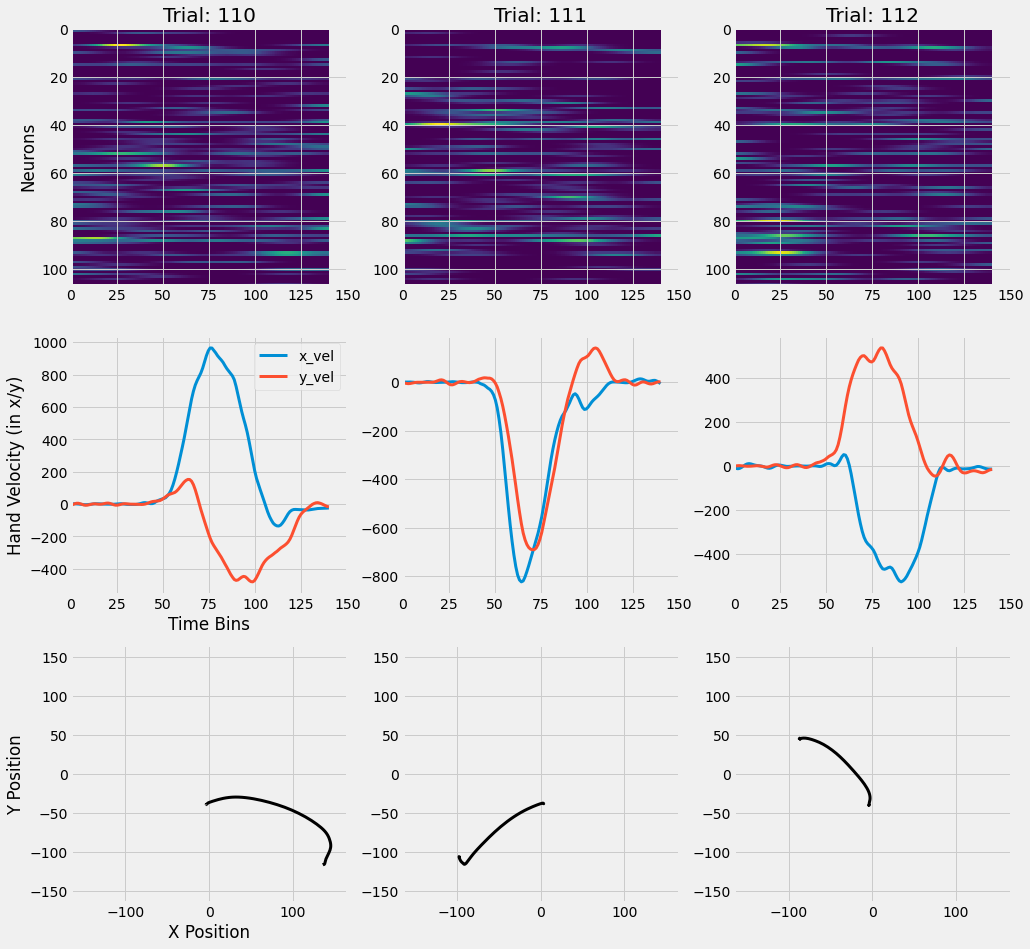

In [33]:
# Visualize smoothed firing rates
def smoothFiring(data, kernel_size, gaussian = True):
    ## TODO: Run a moving-average smoothing filter over the firing rates
    ## Hint: See np.convolve
    if kernel_size > 1:
        if gaussian:
            data = smooth_gaussian(data, kernel_size)
        else:
            kernel = np.ones(kernel_size) / kernel_size
            for i in range(data.shape[1]):
                data[:,i] = np.convolve(data[:,i], kernel, mode= "same")
    #-------------------------------------------
    return data

trials_to_plot = [110, 111,112]
kernel_size = 10
# Play around and plot a few different trials to see how the behavior looks
plot_trials(trial_data, kernel_size = kernel_size, trial_nums = trials_to_plot, gaussian = True)

Now you can see the firing of all of the neurons at once for a trial, but it can be difficult to translate this into an understanding of what is going on at the single neuron level.

To aid in this endeavor, I've provided a second plotting function (that also uses your *smoothFiring* function). Instead of plotting individual trials, I've instead plot the condition-averaged hand velocities and neural firing rates, along with bars that indicate the standard error about the mean.

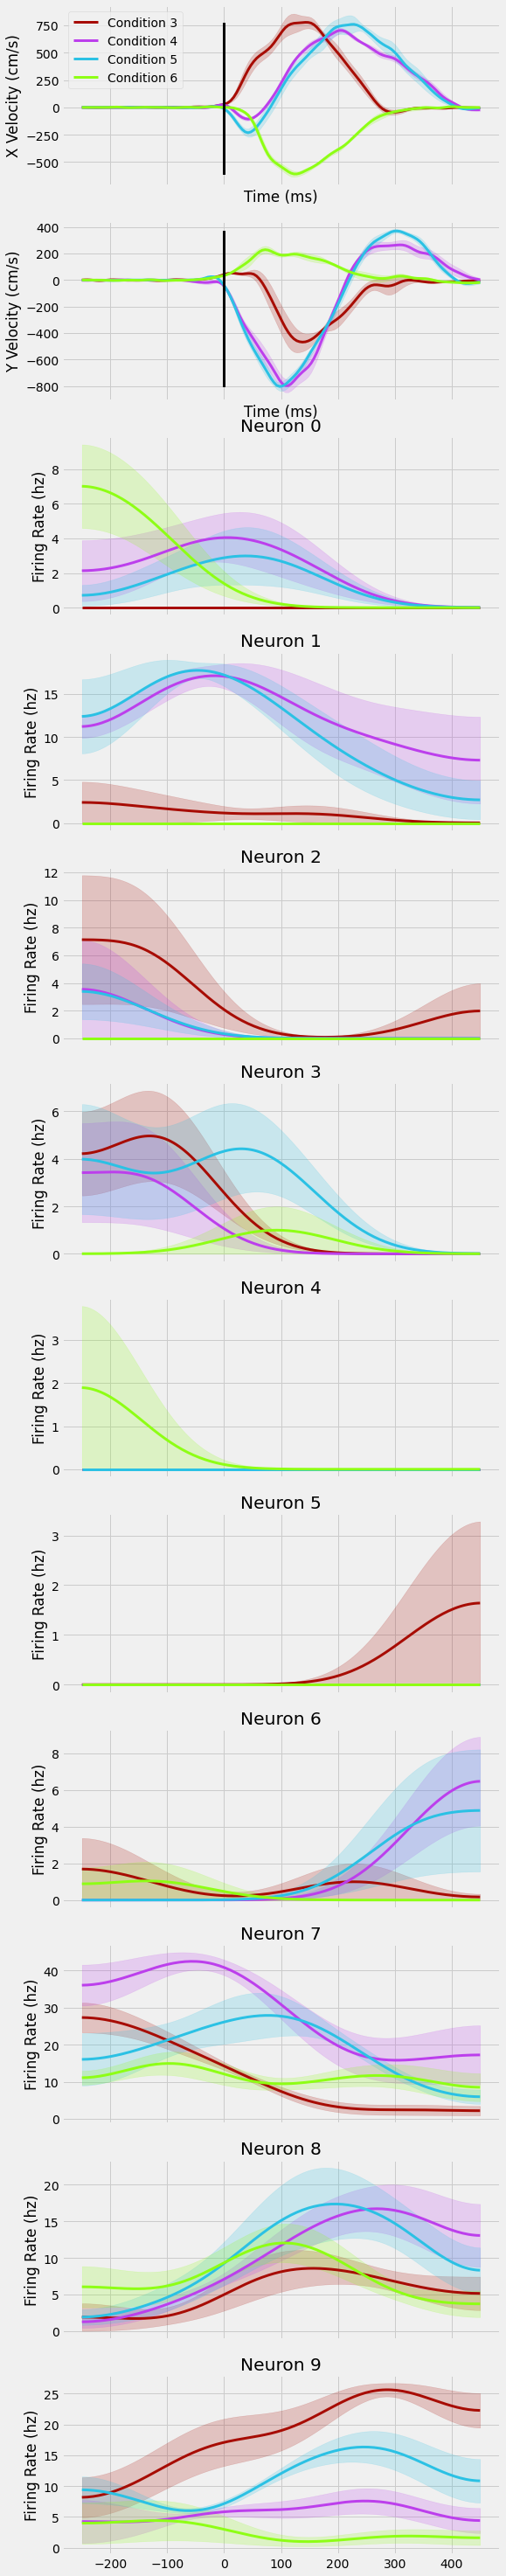

In [87]:
cond_list = np.arange(3, 7)
neuron_list =np.arange(0,10)
plot_FR_conds(trial_data, kernel_size = kernel_size, cond_list = cond_list, neuron_list= neuron_list, gaussian = True)


Take 10 minutes or so to dig around the neural and behavioral data to get a feel for the basic properties of the neural activity.

**Some things to look for:**
- When do these neurons typically change their firing rates during the trial?
- Do these neurons typically increase or decrease their firing rates?
- Can you find any neurons that are strongly related to the hand velocity (or hand position)?

## Trim and package data for training

### Dataloaders

We are going to use PyTorch to train our models, so we now we need to put the data in a format that PyTorch can easily use. 

The standard PyTorch object used to feed data to models is known as a DataLoader. 

**A DataLoader is an object that returns batches of data for training and validation of deep learning models.**

Batch size is an important parameter for training models with Stochastic Gradient Descent (SGD).
- Small batch sizes can lead to high variance in estimates of the gradient
- Large batch sizes can make training extremely slow and memory-intensive.

The DataLoaders handle the process of grabbing batches of data from the dataset and feeding them to your model during the training and validation loops. 



### Your task:

**We will make four dataloaders in total**
- 2D training dataloader
- 2D validation dataloader
- 3D training dataloader
- 3D validation dataloader

**Each dataloader should return four fields**
- heldin spiking, 
- reconstructed spiking 
- hand velocities (for comparing model performance)
- Condition information

The 2D dataloaders should return spiking activity that is "stacked" across trials (i.e., a 2D Tensor of dimension (BxT) x N, where B is the number of trials, T is the trial length, and N is the number of neurons), while the 3D dataloaders should return a 3D spiking tensor (BxTxN).

We will use these array and tensor dataloaders for our vanilla autoencoders and sequential autoencoders respectively.

**Complete the missing code to construct the dataloaders!**

In [35]:
def make_array_dataloader(dataset, spk_field, hospk_field, align_field, align_window,
                    trial_split):
    # TODO: Complete the missing sections of this code
    # Inputs: dataset-      The NWB dataset (not the trialized format) that will be the source of the training/validation data
    #         spk_field-    A string that represents the field of "heldin" spikes, in this case "spikes"
    #         hospk_field-  A string containing the field of "heldout" spikes, in this case "heldout_spikes"
    #         align_field-  A string containing the field on which the trials should be aligned. Typically "move_onset_time"
    #         align_window- A tuple of ints that designate how to cut the trials around the alignment window (in ms)
    #         trial_split-  The trials to be used to generate the dataloader ("train" or "val")
    # 
    # Returns: dataloader-  DataLoader object containing a 2D tensor with dimension (BxT) x N, where B is the number of trials, T is the trial length, and N is the number of neurons 
    #          dataset-     List containing 3 Tensor objects, the heldin spiking, the reconstructed spiking, and the velocity.

    split_to_mask = lambda x: (dataset.trial_info.split == x) if isinstance(x, str) else x
    trial_mask = split_to_mask(trial_split)
    allow_nans = trial_split != "train"
    trial_data = dataset.make_trial_data(ignored_trials=~trial_mask, allow_nans=allow_nans, align_field = align_field, align_range = align_window)
    trial_data = add_conds_to_trial_data(trial_data, dataset)

    # ---------------------For the students -----------------------------------
    # These lines should pull the required spiking data from the trial_data structure
    heldin = torch.Tensor(trial_data[spk_field].to_numpy())
    heldout = torch.Tensor(trial_data[hospk_field].to_numpy())
    vel = torch.Tensor(trial_data["hand_vel"].to_numpy())
    conds = torch.Tensor(trial_data["trial_cond"].to_numpy())
    # --------------------------------------------------------------------------

    print(f"Shape of heldin array {heldin.shape}.")
    print(f"Shape of heldout array {heldout.shape}.")
    print(f"Shape of vel array {vel.shape}.")

    recon_data = torch.cat([heldin, heldout], dim =1)

    tensors = [heldin, recon_data, vel, conds]
    array_dataset = TensorDataset(heldin, recon_data, vel, conds)


    dataloader = DataLoader(array_dataset,
                                batch_size = 200,
                                num_workers = 4,
                                shuffle = True)
    return dataloader, tensors

def make_tensor_dataloader(dataset, spk_field, hospk_field, align_field, align_window,
                    trial_split, align_field_fwd, align_window_fwd):

    # TODO: Complete the missing sections of this code
    # Inputs: dataset-      The NWB dataset (not the trialized format) that will be the source of the training/validation data
    #         spk_field-    A string that represents the field of "heldin" spikes, in this case "spikes"
    #         hospk_field-  A string containing the field of "heldout" spikes, in this case "heldout_spikes"
    #         align_field-  A string containing the field on which the trials should be aligned. Typically "move_onset_time"
    #         align_window- A tuple of ints that designate how to cut the trials around the alignment window (in ms)
    #         trial_split-  The trials to be used to generate the dataloader ("train" or "val")
    # 
    # Returns: dataloader-  DataLoader object containing a 3D tensor with dimension B x T x N, where B is the number of trials, T is the trial length, and N is the number of neurons
    #          dataset-     List containing 3 Tensor objects, the heldin spiking, the reconstructed spiking, and the velocity.

    split_to_mask = lambda x: (dataset.trial_info.split == x) if isinstance(x, str) else x
    trial_mask = split_to_mask(trial_split)
    allow_nans = trial_split != "train"
    trial_data = dataset.make_trial_data(ignored_trials=~trial_mask, allow_nans=allow_nans, align_field = align_field, align_range = align_window)
    trial_data = add_conds_to_trial_data(trial_data, dataset)

    trial_data_fwd = dataset.make_trial_data(ignored_trials=~trial_mask, allow_nans=allow_nans, align_field = align_field_fwd, align_range = align_window_fwd)
    trial_data_fwd = add_conds_to_trial_data(trial_data_fwd, dataset)

    grouped = list(trial_data.groupby('trial_id', sort=False))
    grouped_fwd = list(trial_data_fwd.groupby('trial_id', sort=False))

    # ---------------------For the students -----------------------------------
    # These lines should pull the required spiking data from the trial_data structure
    heldin = torch.Tensor(np.stack([trial[spk_field].to_numpy() for _, trial in grouped]))
    heldout = torch.Tensor(np.stack([trial[hospk_field].to_numpy() for _, trial in grouped]))
    heldin_fwd = torch.Tensor(np.stack([trial[spk_field].to_numpy() for _, trial in grouped_fwd]))
    heldout_fwd = torch.Tensor(np.stack([trial[hospk_field].to_numpy() for _, trial in grouped_fwd]))
    vel= torch.Tensor(np.stack([trial["hand_vel"].to_numpy() for _, trial in grouped]))
    conds = torch.Tensor(np.stack([trial["trial_cond"].to_numpy() for _, trial in grouped]))

    # --------------------------------------------------------------------------

    print(f"Shape of heldin tensor {heldin.shape}.")
    print(f"Shape of heldout tensor {heldout.shape}.")
    print(f"Shape of heldin tensor fwd {heldin_fwd.shape}.")
    print(f"Shape of heldout tensor fwd {heldout_fwd.shape}.")

    # ---------------------For the students ----------------------------------- 
    heldin_full = torch.cat([heldin, heldin_fwd], dim=1)
    heldout_full = torch.cat([heldout, heldout_fwd], dim = 1)
    recon_data = torch.cat([heldin_full, heldout_full], dim =2)
    # --------------------------------------------------------------------------

    print(f"Shape of recon tensor {recon_data.shape}.")
    print(f"Shape of vel tensor {vel.shape}.")

    tensors = [heldin, recon_data, vel, conds]
    tensor_dataset = TensorDataset(heldin, recon_data, vel, conds)
    dataloader = DataLoader(tensor_dataset,
                                    batch_size = 25,
                                    num_workers = 4,
                                    shuffle = True)
    return dataloader, tensors


    
print("+++++++++++++++++Array Train+++++++++++++++++++")
dl_array_train, ds_array_train = make_array_dataloader(dataset, spk_field = "spikes", hospk_field="heldout_spikes", 
                                    align_field = "move_onset_time", align_window= (-250, 450),
                                    trial_split= "train")

print("+++++++++++++++++Array Eval+++++++++++++++++++")
dl_array_eval, ds_array_eval =  make_array_dataloader(dataset, spk_field = "spikes", hospk_field="heldout_spikes", 
                                    align_field = "move_onset_time", align_window= (-250, 450),
                                    trial_split= "val")

print("+++++++++++++++Tensor Train++++++++++++++++++++")
dl_tensor_train, ds_tensor_train = make_tensor_dataloader(dataset, spk_field = "spikes", hospk_field="heldout_spikes", 
                                    align_field = "move_onset_time", align_window= (-250, 450),
                                    align_field_fwd= "move_onset_time", align_window_fwd= (450,650),
                                    trial_split= "train")
                                    
print("++++++++++++++++Tensor Eval++++++++++++++++++++")
dl_tensor_eval, ds_tensor_eval = make_tensor_dataloader(dataset, spk_field = "spikes", hospk_field="heldout_spikes", 
                                    align_field = "move_onset_time", align_window= (-250, 450),
                                    align_field_fwd= "move_onset_time", align_window_fwd= (450,650),
                                    trial_split= "val")



+++++++++++++++++Array Train+++++++++++++++++++
Shape of heldin array torch.Size([10500, 107]).
Shape of heldout array torch.Size([10500, 35]).
Shape of vel array torch.Size([10500, 2]).
+++++++++++++++++Array Eval+++++++++++++++++++
Shape of heldin array torch.Size([3500, 107]).
Shape of heldout array torch.Size([3500, 35]).
Shape of vel array torch.Size([3500, 2]).
+++++++++++++++Tensor Train++++++++++++++++++++
Shape of heldin tensor torch.Size([75, 140, 107]).
Shape of heldout tensor torch.Size([75, 140, 35]).
Shape of heldin tensor fwd torch.Size([75, 40, 107]).
Shape of heldout tensor fwd torch.Size([75, 40, 35]).
Shape of recon tensor torch.Size([75, 180, 142]).
Shape of vel tensor torch.Size([75, 140, 2]).
++++++++++++++++Tensor Eval++++++++++++++++++++
Shape of heldin tensor torch.Size([25, 140, 107]).
Shape of heldout tensor torch.Size([25, 140, 35]).
Shape of heldin tensor fwd torch.Size([25, 40, 107]).
Shape of heldout tensor fwd torch.Size([25, 40, 35]).
Shape of recon ten

This code should return:
<blockquote>
+++++++++++++++++Array Train+++++++++++++++++++<br>
Shape of heldin array torch.Size([10500, 107]).<br>
Shape of heldout array torch.Size([10500, 35]).<br>
Shape of vel array torch.Size([10500, 2]).<br>
+++++++++++++++++Array Eval+++++++++++++++++++<br>
Shape of heldin array torch.Size([3500, 107]).<br>
Shape of heldout array torch.Size([3500, 35]).<br>
Shape of vel array torch.Size([3500, 2]).<br>
+++++++++++++++Tensor Train++++++++++++++++++++<br>
Shape of heldin tensor torch.Size([75, 140, 107]).<br>
Shape of heldout tensor torch.Size([75, 140, 35]).<br>
Shape of heldin tensor fwd torch.Size([75, 40, 107]).<br>
Shape of heldout tensor fwd torch.Size([75, 40, 35]).<br>
Shape of recon tensor torch.Size([75, 180, 142]).<br>
Shape of vel tensor torch.Size([75, 140, 2]).<br>
+++++++++++++++Tensor Eval++++++++++++++++++++<br>
Shape of heldin tensor torch.Size([25, 140, 107]).<br>
Shape of heldout tensor torch.Size([25, 140, 35]).<br>
Shape of heldin tensor fwd torch.Size([25, 40, 107]).<br>
Shape of heldout tensor fwd torch.Size([25, 40, 35]).<br>
Shape of recon tensor torch.Size([25, 180, 142]).<br>
Shape of vel tensor torch.Size([25, 140, 2]).<br>

</blockquote>

Overall:
- 75 training trials
- 25 eval trials
- 140 time points (without forward pred)
- 180 time points (forward pred)
- 107 input neurons
- 142 output neurons

**With these dataloaders, we can begin to model the neural activity!**

# Part 2: Vanilla Autoencoder

First things first: how well can we model these data with a simple nonlinear autoencoder?<br>
You should remember this from last Friday, but as a refresher:

Autoencoders are models that attempt to denoise data by compressing it through an informational bottleneck.

These models typically have two components:
- **Encoders**, which receive the high-D input data and project it down to a low-D representation (the "latent space").
- **Decoders**, which take this low-D representation and attempt to regenerate the high-D input data.

Because the latent space is much smaller than the data space, pushing data through an autoencoder can denoise the input signals.



![title](../../images/ae.png)
https://www.compthree.com/blog/autoencoder/


For our autoencoder, we will be using a multi-layer neural network, and training the weights of this network via backpropagation of gradients.

I've provided a skeleton for an autoencoder network below. The encoder and decoder each have two layers of different sizes.

**Fill out the missing code to construct an autoencoder with the requirements in the description.**

Note that for this model, we are not doing any forward predictions, as simple autoencoders don't model any relationship of the data in time.
In other words, each sample is treated as independent from all other samples. This means that this model won't capture any dynamics that I explained in the introduction.

(Also, this model isn't *technically* an autoencoder, because we are asking the decoder to predict the activity of neurons that the encoder did not see. For simplicity, I am going to call it an autoencoder anyway.)

In [36]:
# Vanilla AE code

class VanillaAE(torch.nn.Module):
  # TODO: Complete the autoencoder model
  # Encoder requirements: 
  #   - ReLU activation functions (look in torch.nn for guidance)
  #   - Input size = n_neurons_in
  #   - Hidden layer sizes : 64, 32 (two hidden layers)
  #   - Output size: latent_dim
  # Decoder requirements:
  #   - Input size = latent_dim
  #   - Hidden layer sizes : 32, 64
  #   - Output size: n_neurons_out

    def __init__(self, n_neurons_in, n_neurons_out, latent_dim):
        super().__init__()
          
        self.n_neurons_in = n_neurons_in
        self.n_neurons_out = n_neurons_out
        self.latent_dim = latent_dim
        #----------------For Students-----------------------
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.n_neurons_in, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, self.latent_dim)
        )
          
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, self.n_neurons_out),
        )
        #----------------------------------------------------

    def forward(self, x):
        # Implement forward pass of AE network. 
        # Be sure to return both the predictions and the latent activity.
        # Remember that the autoencoder is predicting the log-rates, so you have to
        # transform the output of the decoder to the correct domain (0,inf)
        # Hint: Look at Poisson GLM Link functions.
        #----------------For Students-----------------------
        latents = self.encoder(x)
        rates = torch.exp(self.decoder(latents))
        return rates, latents
        #----------------------------------------------------
        

## Prepare to train your autoencoder
Now that you've got an autoencoder model, it's time to train it.
The first thing that we need to do is instantiate our model, our optimizer, and our loss function.

Our loss function is what we are using to calculate the "performance" of the network; in this case, our loss function should measure how well the autoencoder can regenerate the neural activity after passing it through a bottleneck.

In general, while loss functions can be very complex, they are all required to be *differentiable*. This means that you must be able to take the derivative of the loss with respect to the weights of the neural network. Differentiability is a requirement for using the backpropagation algorithm to train a neural network!

One common loss function is known as the Mean-Square-Error (MSE) loss, which takes the mean squared difference between the prediction and the target (see equation below). Linear regression minimizes MSE to fit training data.

Take 5 minutes or so to talk amongst yourselves about what loss functions we might use to train our model.

- What are the statistical properties of our neural spiking data?
- What are the assumptions that we make when we use an MSE loss function?
- Are there any loss functions that would be a better fit (pun intended) for our data?

![title](../../images/mseLoss.png)
https://datascience.stackexchange.com/questions/111296/how-to-calculate-loss-function

In the following section of code, I've provided the bones of a training loop that takes in batches of training data from our 2D training dataloader, feeds it to the model, and updates the weights of the AE to minimize the loss function.

But before we get to training, we have to instantiate and pick a loss function for our model.

First complete the model setup at the top of the code block, then finish the training loop below.

We also want to evaluate our model occasionally on the validation dataset, but don't use that data to train the model.

**Remember that testing on data used to train the model can result in overfitting!**

Complete the blank sections of the code below to allow us to instantiate our model, run the training loop, and log the training and validation losses.

In [73]:
# Setup your optimizers and run your training loop
# Remember: we are feed in only the held-in neurons and predicting the held-out neurons

latent_dim = 20
epochs = 100

outputs = []
losses = []
eval_losses = []

# For our optimizer, we will use ADAM (an optimizer with momentum)
# Use a learning rate of 1e-3 and a weight decay of 0.
#----------------For Students-----------------------
# Instantiate the VanillaAE model
ae_model = VanillaAE(n_neurons_in = 107, n_neurons_out=142, latent_dim = latent_dim)

# Pick a loss function (HINT: Look in torch.nn.functional for some candidates!)
loss_function = F.poisson_nll_loss

# Instantiate your ADAM optimizer. You will have to pass the model's parameters (i.e., the weights of the neural network) to it
# HINT: See if you can find a function in nn.Module that can help 
optimizer = torch.optim.Adam(ae_model.parameters(),
                             lr = 1e-3,
                             weight_decay = 0)
#----------------------------------------------------

# This is where our training loop starts.
# First, we iterate through epochs.
for epoch in range(epochs):
  # if the epoch is even, we should compute a validation loss
  if np.mod(epoch, 2)==0:
    epoch_eval_loss = []
    print("Epoch: {}".format(epoch))
    ae_model.eval() # We need to tell the model that we are in Eval mode, rather than training mode
    #------------------For Students------------------------
    for (eval_batch, eval_recon, eval_vel, eval_conds) in dl_array_eval:
      reconstructed, latents = ae_model(eval_batch)
      eval_loss = loss_function(reconstructed, eval_recon, log_input=False)
    #------------------------------------------------------
      eval_losses.append([epoch, eval_loss.detach().numpy()])
      epoch_eval_loss.append(eval_loss.detach().numpy())

    print(f"Validation Loss: {np.mean(epoch_eval_loss):0.5f}")
  for (data_batch, data_recon, vel_ds, train_conds) in dl_array_train:
    ae_model.train()
    #------------------For Students------------------------
    # Output of Autoencoder
    reconstructed, latents = ae_model(data_batch)
    # Calculating the loss function
    loss = loss_function(reconstructed, data_recon, log_input=False)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #-----------------------------------------------------
    # Storing the losses in a list for plotting
    losses.append([epoch, loss.detach().numpy()])

      #------------------------------------------------------
  outputs.append((epochs, data_batch, reconstructed))

Epoch: 0
Validation Loss: 1.00870
Epoch: 2
Validation Loss: 0.10760
Epoch: 4
Validation Loss: 0.09383
Epoch: 6
Validation Loss: 0.09226
Epoch: 8
Validation Loss: 0.09218
Epoch: 10
Validation Loss: 0.09215
Epoch: 12
Validation Loss: 0.09187
Epoch: 14
Validation Loss: 0.09001
Epoch: 16
Validation Loss: 0.08921
Epoch: 18
Validation Loss: 0.08783
Epoch: 20
Validation Loss: 0.08556
Epoch: 22
Validation Loss: 0.08490
Epoch: 24
Validation Loss: 0.08409
Epoch: 26
Validation Loss: 0.08209
Epoch: 28
Validation Loss: 0.08082
Epoch: 30
Validation Loss: 0.07956
Epoch: 32
Validation Loss: 0.07746
Epoch: 34
Validation Loss: 0.07609
Epoch: 36
Validation Loss: 0.07501
Epoch: 38
Validation Loss: 0.07389
Epoch: 40
Validation Loss: 0.07273
Epoch: 42
Validation Loss: 0.07165
Epoch: 44
Validation Loss: 0.07090
Epoch: 46
Validation Loss: 0.07013
Epoch: 48
Validation Loss: 0.06960
Epoch: 50
Validation Loss: 0.06901
Epoch: 52
Validation Loss: 0.06849
Epoch: 54
Validation Loss: 0.06802
Epoch: 56
Validation Loss

## How's the model doing?
Now we can look to see how well the vanilla autoencoder models our data. First we are going to just look at the loss.

How many epochs seem to be sufficient to train this model?

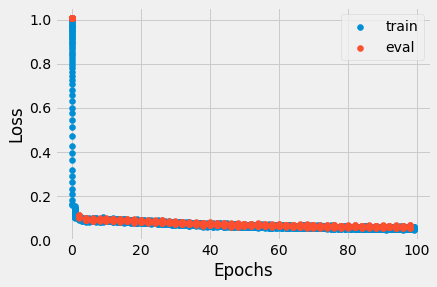

In [74]:
losses_arr = np.array(losses)
eval_losses_arr = np.array(eval_losses)

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Epochs')
plt.ylabel('Loss')
  
# Plotting the last 100 values
plt.scatter(losses_arr[:,0], losses_arr[:,1], label = "train")
plt.scatter(eval_losses_arr[:,0],eval_losses_arr[:,1], label = "eval")
plt.legend()

## From neural firing to latent variables to neural firing

As a reminder, we've trained a model to compress high-D neural activity through a small latent bottle neck, then decode those latents to reproduce the original neural activity.

Let's inspect our trained model to see what this process looks like. We'll walk through the autoencoder step-by-step:
- The firing rates that we feed into the model
- The latent trajectories
- The decoded firing rates at the output

### Latent Trajectories
We've already inspected the firing rates that we've fed into the model, so we'll start with the latent space.

We call these low-D representations **Latent Variables** or **Neural Latents**.

We can use PCA to reduce our 20D latent state to 3D so that we can visualize how the data behaves in this low-D representation:

I've provided a function that will help you inspect these data
- plot_cond_avg_latent_traj: Plots the condition-averaged or raw latent trajectories for an input list of conditions, smoothed according to an input kernel size.

**Play around with plotting different conditions, kernel sizes, and whether or not to condition average the trials.**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


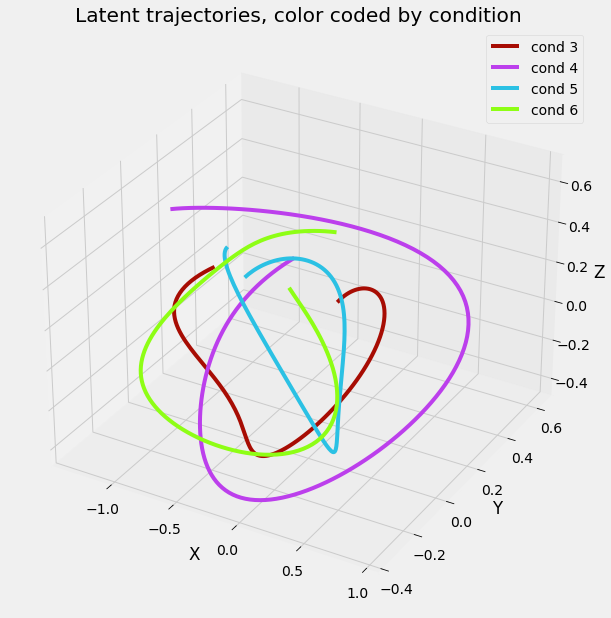

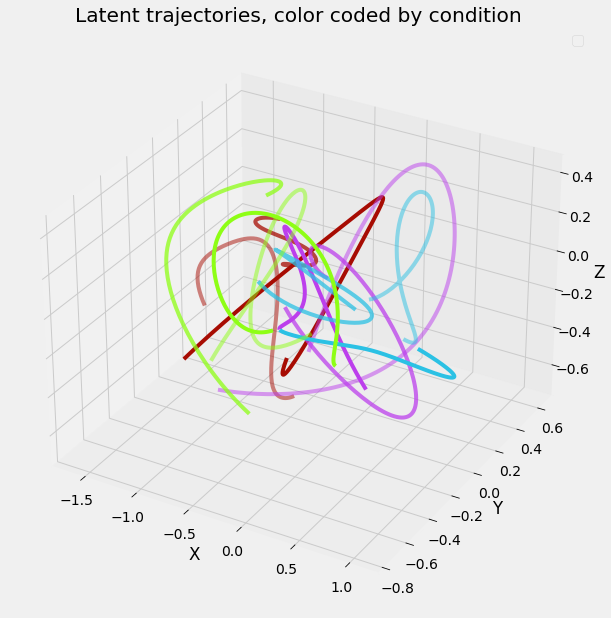

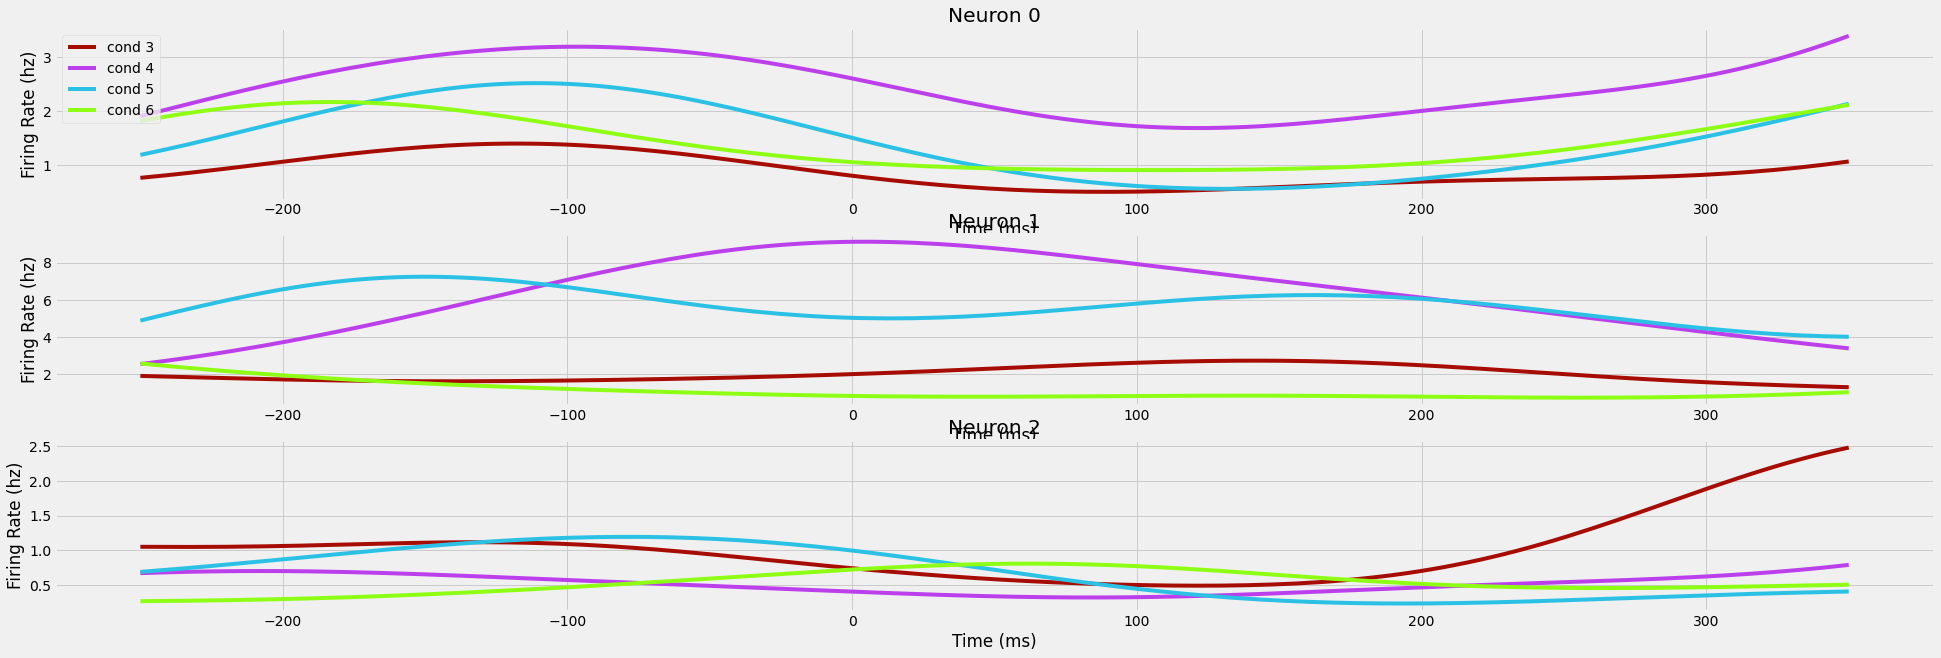

In [88]:

# Run the data through the model to get latent states for every trial
pred_rates, latents = ae_model(ds_array_train[0])
conds = ds_array_train[3]

# Get data ready for plotting
latents_plot = torch.clone(latents)
latents_plot = latents_plot.detach().numpy()

pred_rates_plot = torch.clone(pred_rates)
pred_rates_plot = pred_rates_plot.detach().numpy()

conds_mat = np.reshape(conds, (75, 140))
conds_arr = conds_mat[:,0]

# Parameters to change
# conds_to_plot is the list of conditions that the function should produce trajectories for
conds_to_plot= [3,4,5,6]
kernel_size =  20


cond_avg = True # whether the single trials or condition average should be plotted

plot_cond_avg_latent_traj(latents_plot=latents_plot, conds_trial=conds_arr, conds_to_plot= conds_to_plot, kernel_size=kernel_size, cond_avg= cond_avg)

cond_avg = False
plot_cond_avg_latent_traj(latents_plot=latents_plot, conds_trial=conds_arr, conds_to_plot= conds_to_plot, kernel_size=kernel_size, cond_avg= cond_avg)



cond_avg = True
units_to_plot = [0,1,2]
plot_cond_avg_pred_fr(pred_rates= pred_rates_plot, conds_trial = conds_arr, conds_to_plot = conds_to_plot,
                      units_to_plot = units_to_plot, kernel_size = kernel_size, cond_avg = cond_avg)


There are a few things that you should note in these plots:
- The latent trajectories have some temporal structure
- The single-trial trajectories are more similar to the other trials in the same condition than trials from other conditions
- The data are still quite noisy!

### Reconstructed firing rates

Now we will look at the decoder performance: **how well is our model reconstructing the input data from these latent trajectories?**

I've provided another plotting function that generates plots of predicted and actual firing rates.

Play around with these plots and answer these questions:
- How well is the model doing? (qualitatively)
- Which neurons are being predicted well?
- Which neurons are being predicted poorly?

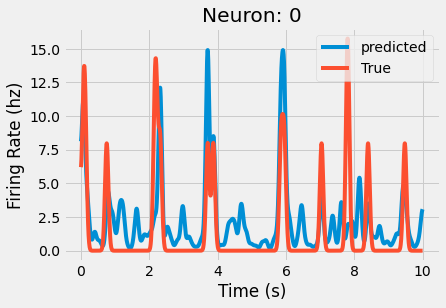

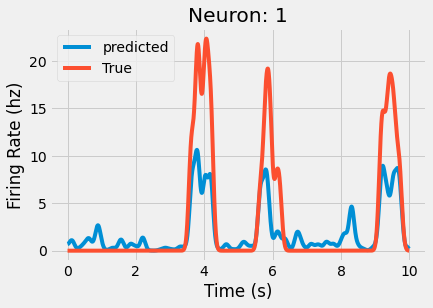

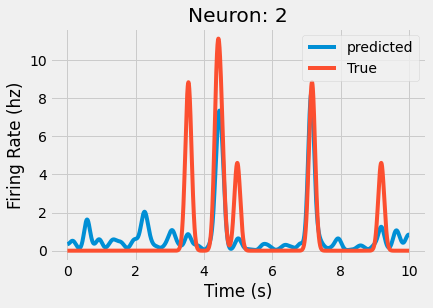

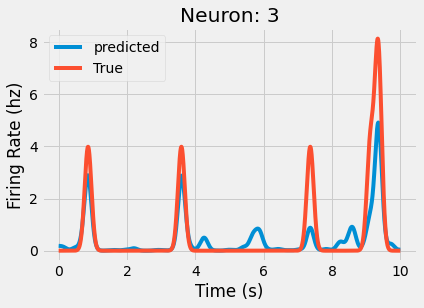

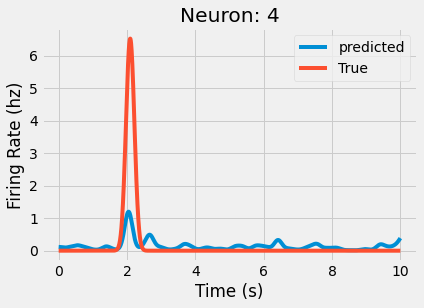

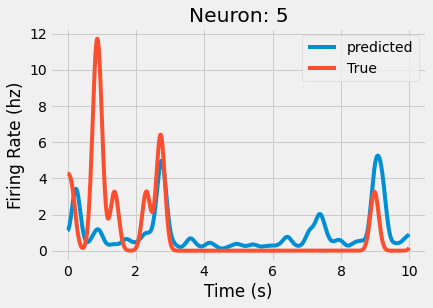

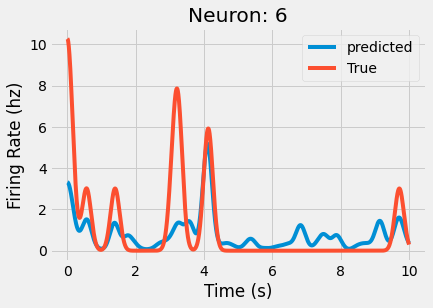

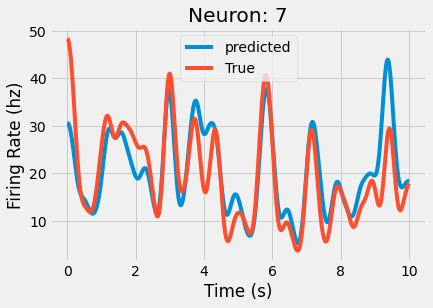

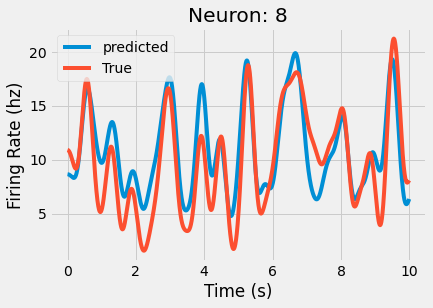

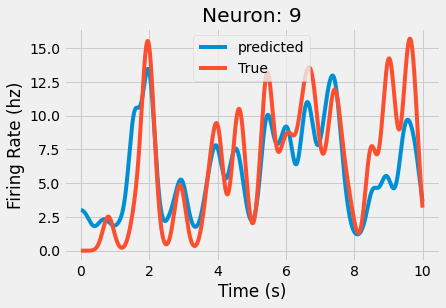

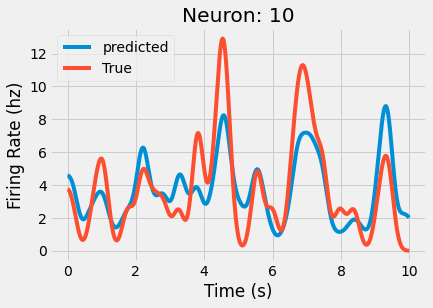

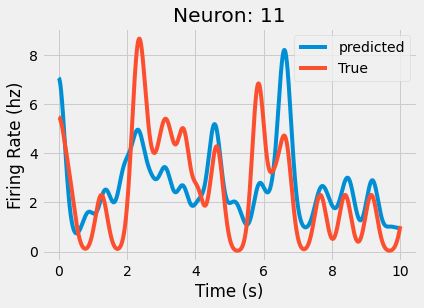

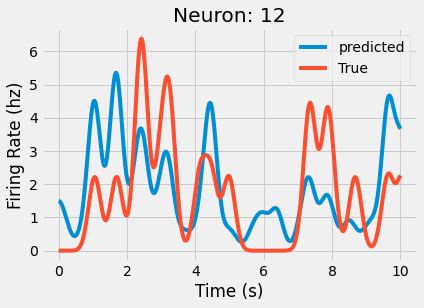

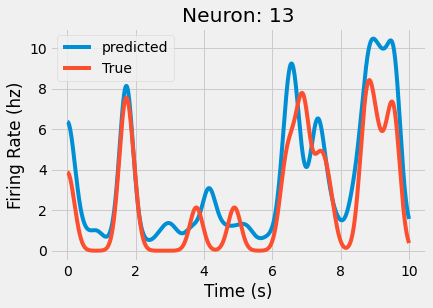

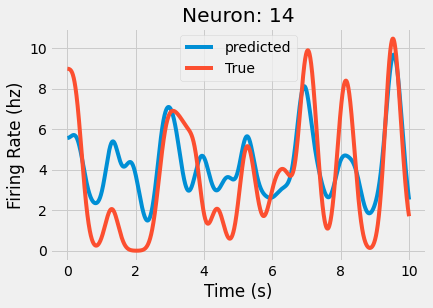

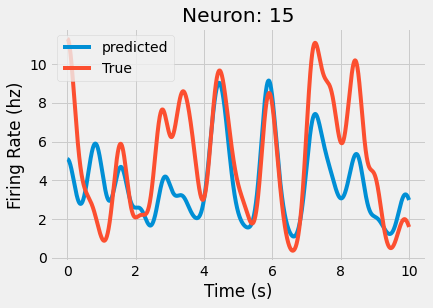

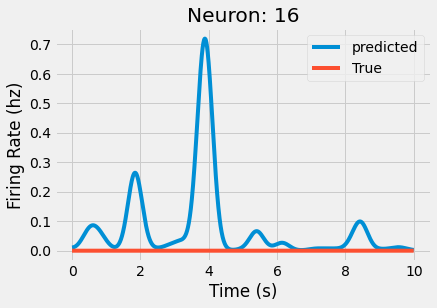

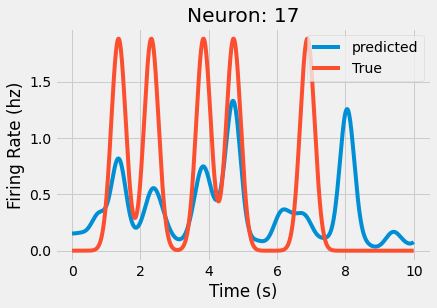

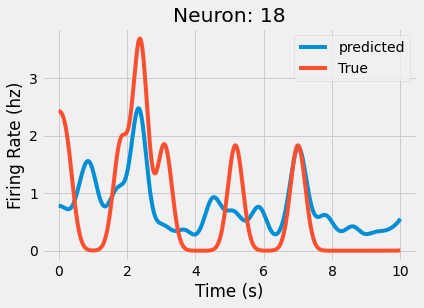

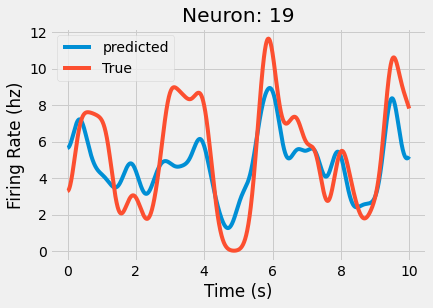

In [40]:
# Pass data through the model
spiking = torch.clone(ds_array_train[0])
spiking = spiking.detach().numpy()
pred_rates_plot = torch.clone(pred_rates)
pred_rates_plot = pred_rates_plot.detach().numpy()

# Plotting params
window = np.array([0, 2000]) # the sample window to plot
kernel_size = 10 # kernel size

# Iterate through and plot the first 20 neurons
for i in range(20): 
    plotPredictedFR(pred_rates_plot, spiking, unitNum= i, kernel_size=kernel_size, window = window)

The AE seems to be doing a decent job a capturing the firing rates of the neurons:

However, we can see that there are some neurons where the model has very poor decoding from the latent state.

Remember that even though we optimize our auto-encoder to maximize reconstruction accuracy that isn't our goal (otherwise, why would we pass the data through a bottleneck at all?). 

We have other data that we can use to quantify how well our model is doing.

**We are now going to test the ability of our model to decode hand velocity and capture the firing rates of the held-out neurons**

In [100]:
# Set the smoothing size
kernel_size = 15

computeHandVelR2(ae_model, ds_array_train= ds_array_train, kernel_size_in= kernel_size, gaussian = True)

R2 of X vel decoding from neurons: 0.5388795822637703
R2 of X vel decoding from latents: 0.21682532262198662
R2 of X vel decoding from autoencoded neurons: 0.4861919591302003

R2 of Y vel decoding from neurons: 0.5049842687839208
R2 of Y vel decoding from latents: 0.1272870889103832
R2 of Y vel decoding from autoencoded neurons: 0.41917312079617386



Take a few minutes to play around the smoothing width and observe its effect on the velocity and heldout spiking predictions.
- Why might the models that decode from the latents perform so much worse?
- What's the best velocity decoding performance that you can get?
- What's the best held-out spiking decoding performance you can get?

# Part 3: Sequential Auto-Encoders

## Why Neural Dynamics are important:
As seen above, there is often a temporal structure to the firing behavior of a population of neurons


Models that can capture that temporal structure may allow us to denoise neural data more effectively than methods that do not take them into account (like the AE above).


**As Jonathan will discuss on Friday, these dynamics might also tell us important information about the neural circuit itself!**


![title](../../images/image2.gif)


### What is a dynamical system?

A dynamical system is a system whose state develops over time as a function of its current state and inputs.

Formally, discrete-time dynamical systems can be described by the equation:

$x_{t+1} = f(x_{t}, u_{t})$ 

where $x$ represents a set of state variables for the system, $u$ represents inputs to the system and $f$ represents a function that relates the current state and inputs to the subsequent state.

The equation $x_{t+1} = f(x_{t}, u_{t})$ is the most general form of a discrete-time dynamical system. The function $f$ can represent any number of highly complex nonlinear relationships between the current and subsequent states.

If we make some assumptions about system, we can simplify these equations dramatically.

First, if the dynamics are linear we can transform

 $x_{t+1} = f(x_{t}, u_{t})$ 
 
 into
 
 $x_{t+1} = Ax_{t} + Bu_{t}$ 

 Second, if we assume no inputs then the dynamics become

 $x_{t+1} = Ax_{t}$

 As we can see, these dynamics can be reduced to a set of repeated multiplications by the same matrix A.

 A dynamical system with no inputs is said to be **autonomous**, meaning that all of the movements of the state are the result of dynamics that originate within the system.


## Recurrent Neural Networks:

Recurrent neural networks (RNNs) add to a standard neural network a "state" that can keep track of previous inputs.

A major motivation for RNNs comes from domains in which the data can be viewed as the product of a serial process, like language.


As an example, consider the following sentence:

> The quick brown fox jumped over the lazy ___

When we read this sentence, our "guess" for what the missing word is incorporates information from the preceding words.

**Importantly, the order of the words matters for the meaning of the sentence!**

> I gave the book to Jim

has a very different meaning than

> I gave Jim to the book

RNNs use a "hidden state" to capture the sequential relationship of these types of data. Each RNN cell stores a value that encodes some representation of the inputs that the cell had seen previously. 

**In this way, the RNN has a "memory" of it's past inputs.** 

## Relating Dynamics and Recurrent Neural Networks:

Now that you understand what "dynamics" are and the basic principles behind RNNs, we can begin to look at how we might use RNNs to denoise neural data.

We are going to start with a very simple form of the RNN, a "Linear" RNN. An example is shown in the figure below

![title](../../images/RNN3Fold.png)


Inside the each RNN unit is a state variable $h$. The state variable $h$ acts recurrently on itself with the matrix $A$ and is affected by $u$ through the matrix $B$.

Matrices $A$ and $B$ are parameters of a neural network that can be trained via gradient descent.

At each time step, $h$ is updated as a function of $h$ and $u$ through $A$ and $B$. We can unroll this network over time to look at it more closely.

![title](../../images/RNN3UnFold.png)


Seem familiar?

The RNN update equations

$h_{t+1} = Ah_{t} + Bu_{t}$

are able to model linear dynamical system of the form

$x_{t+1} = Ax_{t} + Bu_{t}$

simply by learning the A and B matrices via backpropagation!

There are many different types of RNNs, but their major differences arise in precisely how the next state is computed using the previous state and inputs. For instance, linear RNNs use a linear combination of the input and hidden state at time t to update the state at t+1. 

**Because Linear RNNs model the dynamics with a matrix $A$, they can only capture systems with linear dynamics**

I have provided some code below that you can use to find what sorts of systems can be captured by linear dynamics!

[[ 0.5 -0.4]
 [-0.4  0.5]]


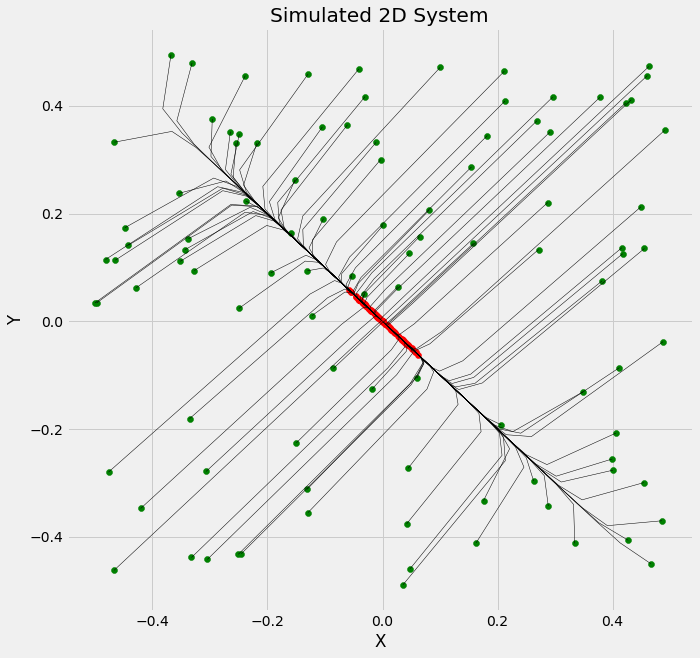

In [89]:
# Some example A matrices and their behavior when used to simulate a dynamical system
# Feed these matrices into the simulate_system function to visualize the sorts of behavior that different A matrices can produce.
# you can also try some out for yourself!

fast_slow_attractor = np.array([[.5, -.4], [-.4, .5]]) 
node = np.array([[0.95, 0], [0, .95]])
spiral_repulsor = np.array([[.99, -1], [1, .99]])

simulate_system(fast_slow_attractor, n_inits=100, n_steps =20)

How about the system from the introduction? Can we simulate these neural dynamics in the same way?

![title](../../images/Dyn1.png)
![title](../../images/Dyn2.png)



[[0 1 0]
 [0 0 1]
 [1 0 0]]


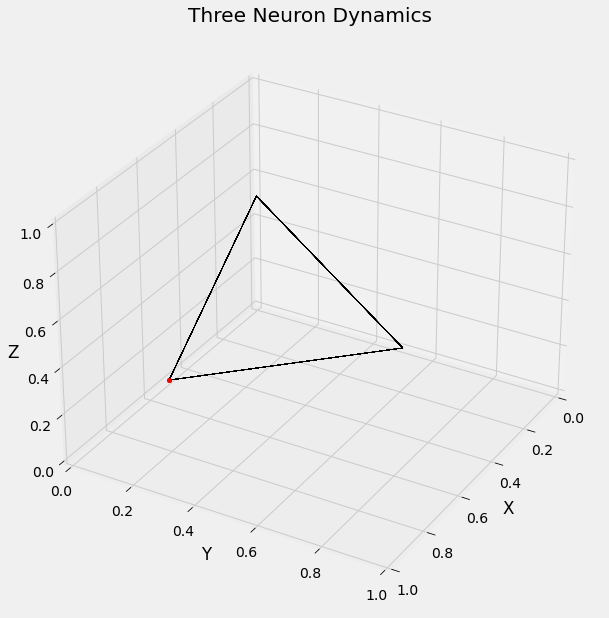

In [90]:
circle_neurons = np.array([[0,1,0],[0,0,1],[1,0,0]])

init_state = np.array([0.5,0,0])

simulate_3D_system(circle_neurons, init_state, 100)


**Linear dynamics are expressive, but can only capture the behavior shown in the figure below:**

![title](../../images/LinDynSystems.jpeg)

https://discourse.julialang.org/t/plotting-dynamical-systems-trajectories/46166

They can't capture the Lorenz system, for example.

![title](../../images/image2.gif)


Note two very important things about these simulations:
- The intial conditions (green dots) determine precisely how the state will develop (because the dynamics are autonomous)
- Different regions have different dynamics (i.e., where you are determines where you will go)

**Therefore, any model of neural dynamics will need to perform two critical tasks:**
1. **Estimate initial conditions**
2. **Model the dynamics**

## Sequential Auto-Encoder Model

Now we will start to write the code that will allow us to model the dynamics of the motor cortex during the reaching task we worked with above!

**The diagram below shows the two most important components of a state-of-the-art latent variable model known as Latent Factor Analysis via Dynamical Systems (LFADS)**
- Encoder: Transforms spiking activity into a set of initial conditions (g0) of a dynamical system
- Decoder/Generator: Simulates the development of a dynamical system over time g(t).

This model is known as a **Sequential Auto-Encoder**, because it *encodes* the neural activity into an initial condition in a low-D latent space, then *decodes* the activity with a dynamics model.

![title](../../images/LFADS_architecture.png)


LFADS is trained to reduce the error between the predicted n(t) and the "true" n(t). It uses an encoder to find initial conditions and a Generator that models the latent dynamics of the circuit.

**Importantly, the dynamics model $g(t)$ is lower dimensional than the neural activity $n(t)$**

**This means that the dynamics are not unfolding in the "neural space", but in a lower dimensional "latent space" (analogous to the hidden layer of our AE network)**

## Steps to get to LFADS:

1. **Estimate initial conditions as simply as possible**
2. **Model dynamics with linear RNN**
3. **Model dynamics with Gated recurrent unit (GRU) RNN**
4. **Estimate initial conditions using GRU**
5. Variational Training
6. Non-autonomous dynamics

We will only get to step 4 today, but there is code available online for you to run the full LFADS model on these data if you are interested!

### Step 1: Estimate initial conditions as simply as possible:

We are going to need to find initial conditions if we want our sequential auto-encoder model to work.

We are eventually going to use an RNN to do this too, but for now let's just use the simplest model at our disposal: simple linear regression.

We're going to take the whole trial worth of firing data and feed it all to a linear model that will predict initial conditions for our RNNs.

The dimensions of this linear model will be:
- input: Heldin_neurons x num_bins
- output: hidden size

Complete the LinearEncoder class below!

In [44]:
class LinearEncoder(nn.Module):
  def __init__(self, input_size,trial_len, hidden_size):
    super().__init__()
    # TODO: Complete the init function
    #---------------Student's work------------------------------------------
    self.input_size = input_size
    self.trial_len = trial_len
    self.hidden_size = hidden_size
    self.encoder = nn.Linear(input_size*trial_len, hidden_size)
    #-----------------------------------------------------------------------
  def forward(self, input):
    # TODO: Complete the forward pass for the LinearEncoder
    n_trials, n_time, n_neurons = input.shape
    input = torch.reshape(input, (n_trials, -1))
    ics =self.encoder(input)
    return ics

lin_enc = LinearEncoder(107, 140, 40)
ics = lin_enc(ds_tensor_train[0])
print(ics.shape)

torch.Size([75, 40])


### Step 2: Linear RNN to model dynamics

Linear RNNs are very simple to code and understand, but can't capture complex systems as well as GRUs. You will learn to code both RNN cells in this tutorial, starting with the Linear RNN below.

As described above, Linear RNN cells only use linear weights to govern the state update. I have provided an abstract RNN class that handles the passing of inputs to the RNNs, so all you have to concern yourself with is the state update for the Linear RNN.


In [45]:
class AbstractRNN(nn.Module):
  def __init__(self, cell, fwd_steps):
    super().__init__()
    self.cell = cell
    self.fwd_steps = fwd_steps

  def forward(self,input, h_0):
    hidden = h_0
    n_batch, n_time, n_inputs = input.shape
    states = torch.zeros(n_batch, n_time, self.cell.hidden_size)
    for i, input_step in enumerate(input.transpose(0,1)):
      hidden = self.cell(input_step, hidden)
      states[:, i,:] = hidden
    return states, hidden

Mathematically your Linear RNN should perform this operation:

>hidden(t+1) = whh * hidden(t) + wih * hidden(t)

Think how this could be accomplished with a single nn.Linear layer



For this block, each forward pass will receive its hidden state and one time step of input as arguments. The class should perform a single state update each time its forward method is called. 

In [46]:
# 
class LinearRNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    # TODO: Complete the init function
    # Set instance variables
    # Initialize a linear network to update the hidden state using the input and the previous hidden state
    #---------------Student's work------------------------------------------
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
    #-----------------------------------------------------------------------
  def forward(self, input, hidden):
    # TODO: Complete the forward pass for the Linear RNN
    # Stack the inputs and hidden states
    # Pass them through the linear network to update the hidden state
    combined = torch.cat((input, hidden),1)
    hidden =self.in2hidden(combined)
    return hidden

Now that you have a simple Linear RNN cell that performs the state update, we will wrap this class with an Abstract RNN that we will be able to re-use for all of the other RNN cells that we code.


Now that we have a fully-functional RNN cell, let's see how well it works on the neural data.

We'll use a relatively simple version of an architecture called a Sequential Auto-Encoder (SAE). It is called this because its job is to reproduce the input data (the same as the vanilla auto-encoder above), excpet it models the sequential structure of the data. 

**While the vanilla Auto-Encoder treats each sample as independent from every other sample, SAEs require data that maintains the temporal relationship between samples.**

*Luckily, the tensor dataloaders we made above do exactly that!*



The first SAE model that we will code is trained to predict the next time step of neural activity from the current input and the hidden state.

**By learning dynamics of the hidden state (the function $f$ that dictates how the hidden state develops), the RNN can model autonomous dynamics.**

In [47]:
# Vanilla SAE code
class VanillaSAE(torch.nn.Module):
    def __init__(self, 
                input_size = 107, 
                latent_size = 40, 
                out_size = 142,
                encoder = None, 
                decoder_cell = None, 
                fwd_steps = 40):
        super().__init__()
        #---------------Student's work------------------------------------------
        self.encoder = encoder
        self.fwd_steps = fwd_steps
        self.decoder = AbstractRNN(decoder_cell(input_size=1, hidden_size=latent_size), fwd_steps=fwd_steps)
        self.readout = nn.Linear(latent_size, out_size)
        #----------------------------------------------------------------------
  
    def forward(self, x):
        # Implement forward pass of AE network
        #---------------Student's work------------------------------------------
        # print(f"input shape {x.shape}")
        n_batch, n_time, n_heldin = x.shape
        input_fwd = torch.zeros((n_batch, n_time + self.fwd_steps, 1))
        ics = self.encoder(x)
        latents_rnn, hidden = self.decoder(input_fwd,ics)
        # print(f"RNN states shape {latents_rnn.shape}")
        log_rates = self.readout(latents_rnn)
        # print(f"latents {latents.shape}")
        rates = torch.exp(log_rates)
        # print(f"logRates shape {log_rates.shape}")
        #----------------------------------------------------------------------
        return rates, latents_rnn

I know that I've already made you write one training loop, but this is good practice!

**Think about how the data should be fed into the models.**
- What should the dimensionality be?


In [48]:
loss_function = F.poisson_nll_loss
# Build your training loop
epochs = 500
outputs = []

lin_rnn = VanillaSAE(input_size = 107, latent_size = 40, out_size = 142, encoder = LinearEncoder(107, 140, 40), decoder_cell = LinearRNN)
losses = np.zeros(epochs)
print(f"Working on GRU model:")
optimizer = torch.optim.Adam(lin_rnn.parameters(),
                            lr = 1e-3,
                            weight_decay = 1e-8)
eval_losses = []
for epoch in range(epochs):
    if np.mod(epoch, 10)==0:
        epoch_eval_loss = []
        print("Epoch: {}".format(epoch))
        lin_rnn.eval() # We need to tell the model that we are in Eval mode, rather than training mode
        #------------------For Students------------------------
        for (eval_batch, eval_recon, eval_vel, eval_conds) in dl_tensor_eval:
            reconstructed, latents = lin_rnn(eval_batch)
            eval_loss = loss_function(reconstructed, eval_recon, log_input=False)
            #------------------------------------------------------
            eval_losses.append([epoch, eval_loss.detach().numpy()])
            epoch_eval_loss.append(eval_loss.detach().numpy())
        print(f"Validation Loss: {np.mean(epoch_eval_loss):0.5f}")

    for (data_batch, data_recon, vel, train_conds) in dl_tensor_train:
        #------------------For Students------------------------
        # Output of Autoencoder
        rates, latents = lin_rnn(data_batch)
        # Calculating the loss function
        loss = loss_function(rates, data_recon, log_input=False)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #-----------------------------------------------------
        # Storing the losses in a list for plotting
        losses[epoch] = loss.detach().numpy()

    # outputs.append((epochs, data_batch, reconstructed))


Working on GRU model:
Epoch: 0
Validation Loss: 0.99787
Epoch: 10
Validation Loss: 0.27320
Epoch: 20
Validation Loss: 0.10694
Epoch: 30
Validation Loss: 0.09662
Epoch: 40
Validation Loss: 0.09413
Epoch: 50
Validation Loss: 0.09301
Epoch: 60
Validation Loss: 0.09249
Epoch: 70
Validation Loss: 0.09222
Epoch: 80
Validation Loss: 0.09204
Epoch: 90
Validation Loss: 0.09192
Epoch: 100
Validation Loss: 0.09187
Epoch: 110
Validation Loss: 0.09180
Epoch: 120
Validation Loss: 0.09176
Epoch: 130
Validation Loss: 0.09173
Epoch: 140
Validation Loss: 0.09189
Epoch: 150
Validation Loss: 0.09172
Epoch: 160
Validation Loss: 0.09173
Epoch: 170
Validation Loss: 0.09168
Epoch: 180
Validation Loss: 0.09169
Epoch: 190
Validation Loss: 0.09177
Epoch: 200
Validation Loss: 0.09177
Epoch: 210
Validation Loss: 0.09166
Epoch: 220
Validation Loss: 0.09166
Epoch: 230
Validation Loss: 0.09166
Epoch: 240
Validation Loss: 0.09164
Epoch: 250
Validation Loss: 0.09165
Epoch: 260
Validation Loss: 0.09168
Epoch: 270
Valida

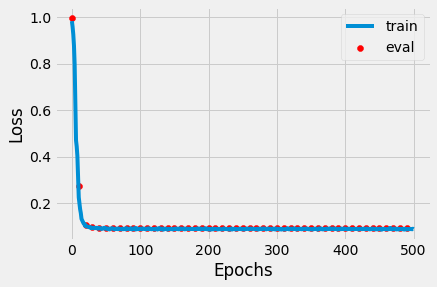

In [49]:
losses_arr = np.array(losses)
eval_losses_arr = np.array(eval_losses)

plt.style.use('fivethirtyeight')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
epoch = np.linspace(0,len(losses_arr), len(losses_arr))
t = np.linspace(0, len(losses_arr),len(losses_arr))
# Plotting the last 100 values
plt.plot(epoch, losses_arr, label = "train")
plt.scatter(eval_losses_arr[:,0],eval_losses_arr[:,1], label = "eval", color = 'r')
plt.legend()

We finally have a working sequential autoencoder!

Let's look to see what the latent trajectories and predicted firing rates look like!

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


R2 of X vel decoding from neurons: 0.5321811687381632
R2 of X vel decoding from latents: 0.0013381810093736624
R2 of X vel decoding from autoencoded neurons: 0.005366671916297472

R2 of Y vel decoding from neurons: 0.48292891758437684
R2 of Y vel decoding from latents: 0.00811123268589442
R2 of Y vel decoding from autoencoded neurons: 0.05501667092805529



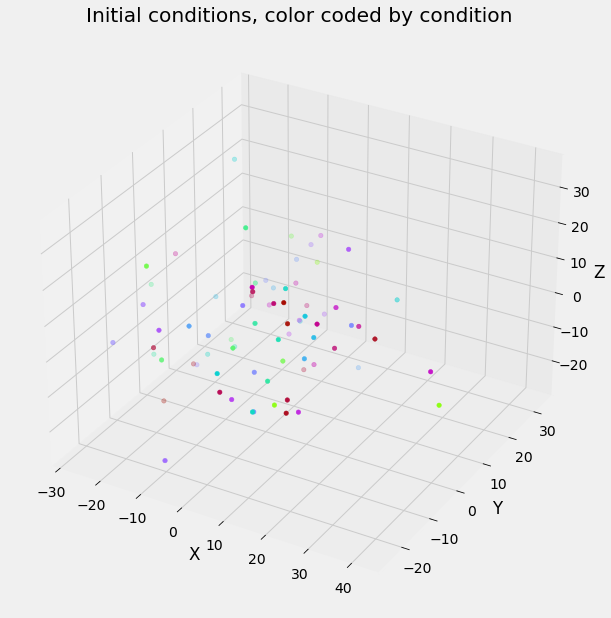

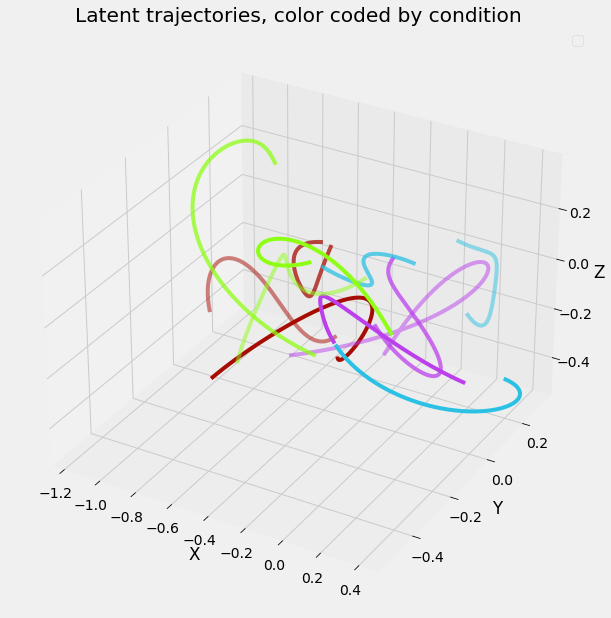

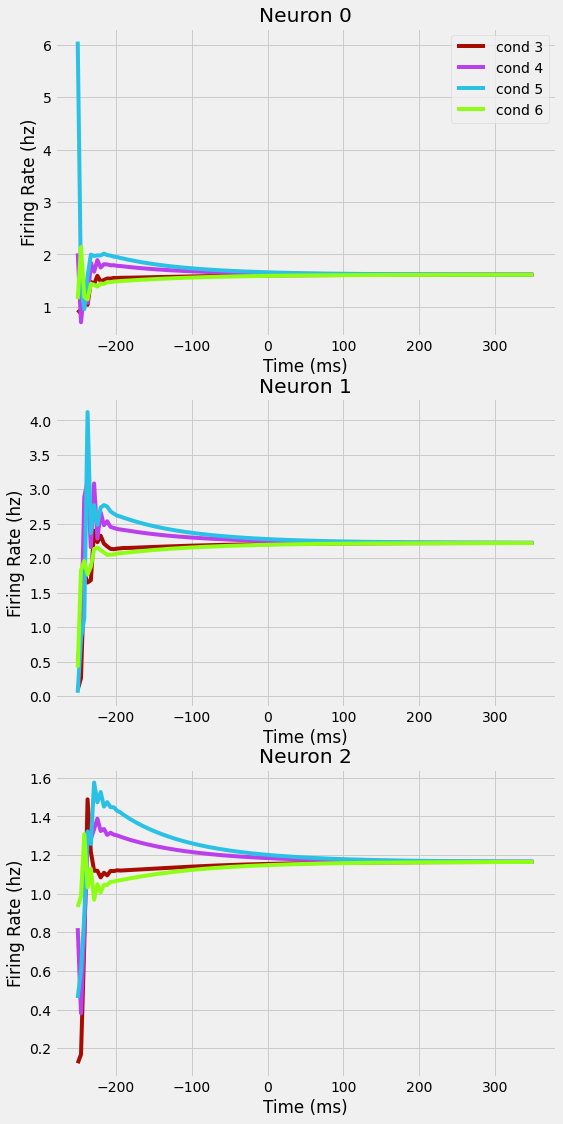

In [96]:
input_data, recon_target, vel, conds = ds_tensor_train 

recon_data, latents = lin_rnn(input_data)
ics = lin_rnn.encoder(input_data)
ics_numpy = ics.detach().numpy()

recon_data_plot = recon_data.detach().numpy()

conds_arr =  conds[:,0]
conds_to_plot = [3,4,5,6]
cond_avg = False

plot_ics(ics_numpy=ics_numpy, cond_arr = conds_arr)
plot_cond_avg_latent_traj(latents_plot=latents_plot, conds_trial=conds_arr, conds_to_plot= conds_to_plot, kernel_size=kernel_size, cond_avg= cond_avg)


computeHandVelR2Tensor(lin_rnn, ds_tensor_train, kernel_size_in=20)


cond_avg = True
units_to_plot = [0,1,2]
plot_cond_avg_pred_fr(pred_rates= recon_data_plot, conds_trial = conds_arr, conds_to_plot = conds_to_plot,
                      units_to_plot = units_to_plot, kernel_size = kernel_size, cond_avg = cond_avg)


### Step 3: Model dynamics using GRU RNN

As we have shown above, linear RNNs have limited expressiveness; they can only model linear dynamical systems!



Even if we were to make the RNN nonlinear, there would still be some major issues, including the **Vanishing Gradient and Long-term Dependency Problems**, that reduce effectiveness on modeling complex datasets!

#### Vanishing Gradient problem


A 1D Linear RNN with no inputs has a single scalar value that determines its recurrent connectivity.

When this RNN updates its state, you can think of it as a recurrent multiplication by a scalar. This can quickly lead to problems where the hidden state "vanishes", making the gradient very small.

This is aptly called the **Vanishing Gradient Problem**


Take as an example a Linear RNN with a initial hidden state of 1.0 and a recurrent weight of 0.5.

If I unroll this RNN over time for just 10 steps, the state would be $1.0 \times 0.5^{10}$  which would be about equal to 0.001.


![title](../../images/Vanishing-Gradient-Problem.png)
https://analyticsindiamag.com/can-relu-cause-exploding-gradients-if-applied-to-solve-vanishing-gradients/

**The vanishing gradient problem can make it difficult to update the weights early in the network because the gradients can get so small!**

#### Long-term Dependency Problem


There is another related issue with these models called the **Long-Term Dependency problem**

Take as an example the following text:
> Jim and I walked to the store, saw Harry, and decided to call two Ubers to drive us to the movie theatre. I don't like Harry very much, so I got in the Uber with ___

You should be able to infer from context that the correct word to insert into the blank is "Jim". Unfortunately, "Jim" was the very first word of the whole sample, meaning that if I wanted to train an RNN to perform this task, **it would need to "remember" Jim for two full sentences!**

For the same reason as the vanishing gradient problem (recurrent multiplication will either vanish or explode) these long-term dependencies pose a major problem for Vanilla RNNs.

**We need a way to "store" memories that is protected from catastrophic forgetting over depth!**

![title](../../images/LongTermProblem.png)

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

#### Gated Recurrent Units solve the Vanishing gradient and long-term dependency problems

GRUs are a more complex non-linear RNNs that have methods to stop the RNN from "forgetting" things that happened a long time ago.

The exact internals of the GRU are beyond the scope of this workshop (see the diagram below), but if you want to code the GRU from scratch there are many good resources online.

Suffice it to say, GRUs have specific internal architectures that solve the vanishing gradient and forgetting issues!

![title](../../images/GRU.png)

https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be

In [51]:
loss_function = F.poisson_nll_loss
from torch.nn import GRUCell
# Build your training loop
epochs = 500
outputs = []

gru_rnn = VanillaSAE(input_size = 107, latent_size = 64, out_size = 142, encoder = LinearEncoder(107, 140, 64), decoder_cell = GRUCell)
losses = np.zeros(epochs)
print(f"Working on GRU model:")
optimizer = torch.optim.Adam(gru_rnn.parameters(),
                            lr = 1e-3,
                            weight_decay = 1e-8)
eval_losses = []
for epoch in range(epochs):
    if np.mod(epoch, 10)==0:
        epoch_eval_loss = []
        print("Epoch: {}".format(epoch))
        gru_rnn.eval() # We need to tell the model that we are in Eval mode, rather than training mode
        #------------------For Students------------------------
        for (eval_batch, eval_recon, eval_vel, asdf) in dl_tensor_eval:
            reconstructed, latents = gru_rnn(eval_batch)
            eval_loss = loss_function(reconstructed, eval_recon, log_input=False)
            #------------------------------------------------------
            eval_losses.append([epoch, eval_loss.detach().numpy()])
            epoch_eval_loss.append(eval_loss.detach().numpy())
        print(f"Validation Loss: {np.mean(epoch_eval_loss):0.5f}")

    for (data_batch, data_recon, vel, asdf) in dl_tensor_train:
        #------------------For Students------------------------
        # Output of Autoencoder
        rates, latents = gru_rnn(data_batch)
        # Calculating the loss function
        loss = loss_function(rates, data_recon, log_input=False)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #-----------------------------------------------------
        # Storing the losses in a list for plotting
        losses[epoch] = loss.detach().numpy()

    # outputs.append((epochs, data_batch, reconstructed))

Working on GRU model:
Epoch: 0
Validation Loss: 1.00950
Epoch: 10
Validation Loss: 0.16097
Epoch: 20
Validation Loss: 0.09961
Epoch: 30
Validation Loss: 0.09573
Epoch: 40
Validation Loss: 0.09511
Epoch: 50
Validation Loss: 0.09463
Epoch: 60
Validation Loss: 0.09426
Epoch: 70
Validation Loss: 0.09396
Epoch: 80
Validation Loss: 0.09368
Epoch: 90
Validation Loss: 0.09349
Epoch: 100
Validation Loss: 0.09332
Epoch: 110
Validation Loss: 0.09318
Epoch: 120
Validation Loss: 0.09334
Epoch: 130
Validation Loss: 0.09297
Epoch: 140
Validation Loss: 0.09311
Epoch: 150
Validation Loss: 0.09297
Epoch: 160
Validation Loss: 0.09286
Epoch: 170
Validation Loss: 0.09292
Epoch: 180
Validation Loss: 0.09307
Epoch: 190
Validation Loss: 0.09304
Epoch: 200
Validation Loss: 0.09286
Epoch: 210
Validation Loss: 0.09277
Epoch: 220
Validation Loss: 0.09303
Epoch: 230
Validation Loss: 0.09278
Epoch: 240
Validation Loss: 0.09283
Epoch: 250
Validation Loss: 0.09295
Epoch: 260
Validation Loss: 0.09303
Epoch: 270
Valida

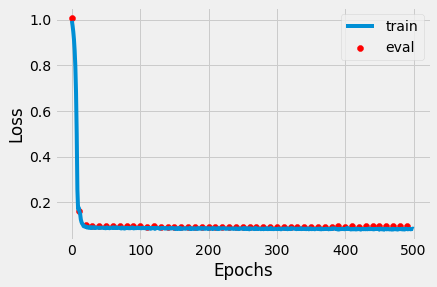

In [52]:
losses_arr = np.array(losses)
eval_losses_arr = np.array(eval_losses)

plt.style.use('fivethirtyeight')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
epoch = np.linspace(0,len(losses_arr), len(losses_arr))
t = np.linspace(0, len(losses_arr),len(losses_arr))
# Plotting the last 100 values
plt.plot(epoch, losses_arr, label = "train")
plt.scatter(eval_losses_arr[:,0],eval_losses_arr[:,1], label = "eval", color = 'r')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


R2 of X vel decoding from neurons: 0.5199465477796349
R2 of X vel decoding from latents: 0.41413978045493127
R2 of X vel decoding from autoencoded neurons: 0.5777710952192778

R2 of Y vel decoding from neurons: 0.4925082839018621
R2 of Y vel decoding from latents: 0.2293372997788431
R2 of Y vel decoding from autoencoded neurons: 0.42022287505889655



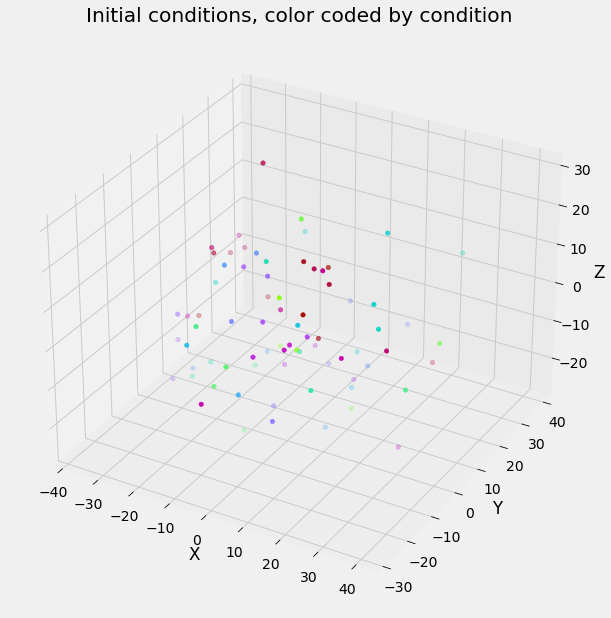

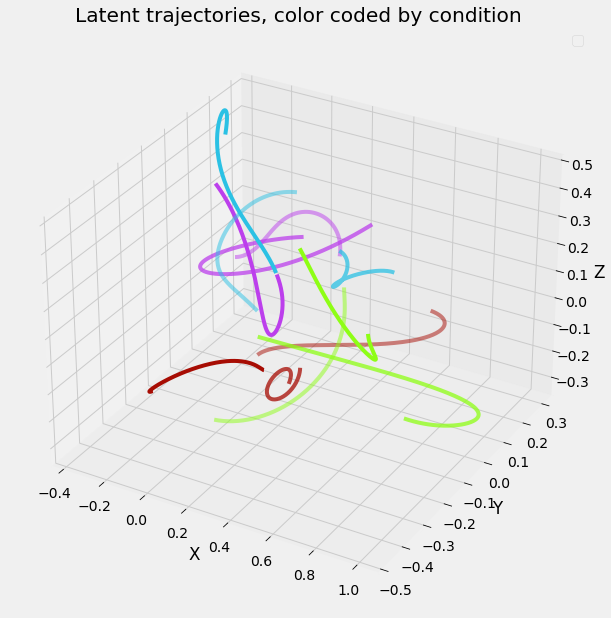

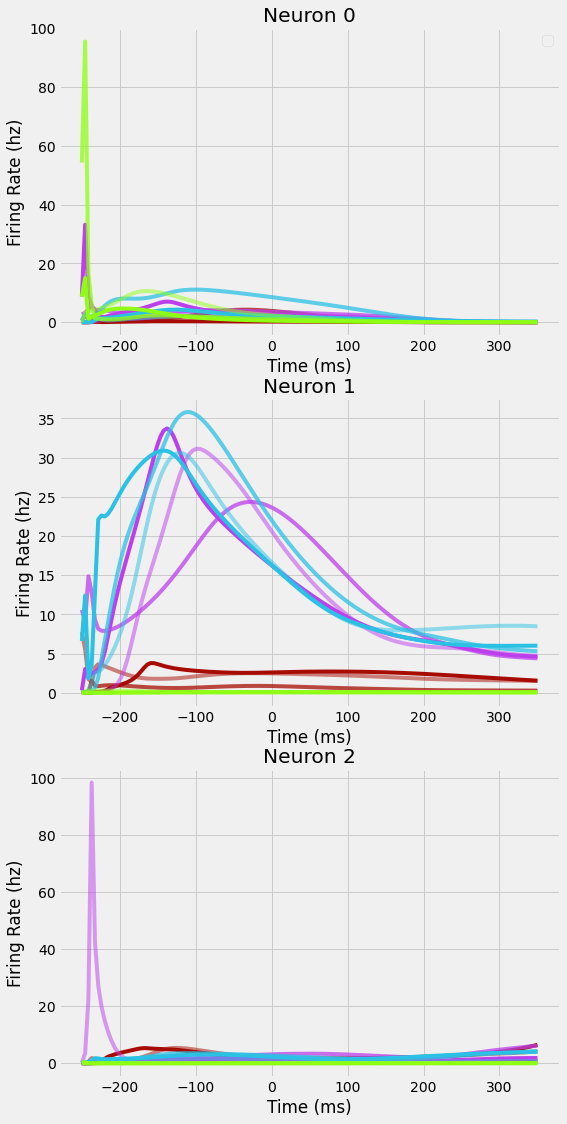

In [98]:
input_data, recon_target, vel, conds = ds_tensor_train 

recon_data, latents = gru_rnn(input_data)
ics = gru_rnn.encoder(input_data)
ics_numpy = ics.detach().numpy()
recon_data_plot = recon_data.detach().numpy()

conds_arr =  conds[:,0]
conds_to_plot = [3,4,5,6]
cond_avg = False

plot_ics(ics_numpy=ics_numpy, cond_arr = conds_arr)
plot_cond_avg_latent_traj(latents_plot=latents_plot, conds_trial=conds_arr, conds_to_plot= conds_to_plot, kernel_size=kernel_size, cond_avg= cond_avg)
computeHandVelR2Tensor(gru_rnn, ds_tensor_train=ds_tensor_train, kernel_size_in=10)

cond_avg = False
units_to_plot = [0,1,2]
plot_cond_avg_pred_fr(pred_rates= recon_data_plot, conds_trial = conds_arr, conds_to_plot = conds_to_plot,
                      units_to_plot = units_to_plot, kernel_size = kernel_size, cond_avg = cond_avg)



**Run the training loop above to see how well the GRU models the data!**

### Step 4: Estimation ICs using GRU network

Now we are getting pretty close to LFADS, but our simple encoder architecture may needs some tweaking.

One way that we can improve the encoders is to use GRUs instead of a simple linear regression, which will allow us to model nonlinearities in the relationship between neural firing and the initial conditions of a trial.

A GRU encoder will also make it easier to use the same model with different time windows!

Coding these new encoders are a little complicated, but can be broken into a few steps
- Feed trial into encoder, output hidden state at end of encoder pass
- Feed trial into encoder backwards (bidirectional)
- Concatenate forward and reverse passes of GRU encoders.
- Linearly project to hidden size of Generator network for ICs.

Luckily, the GRU module in pytorch can simplify this process greatly through its "bidirectional" flag.

Passing

> bidirectional = True 

into the GRU network runs the encoder model backwards and forwards on the input data and returns the hidden states stacked along the last dimension of the output tensor.


![title](../../images/BiGru.png)

https://ieeexplore.ieee.org/document/8713663


In [54]:
# Vanilla SAE code
class RNN(nn.Module):
    def __init__(self, cell):
        super().__init__()
        self.cell = cell

    def forward(self, input, h_0):
        hidden = h_0
        states = []
        for input_step in input.transpose(0, 1):
            hidden = self.cell(input_step, hidden)
            states.append(hidden)
        states = torch.stack(states, dim=1)
        return states, hidden

class GRUSAE(torch.nn.Module):
    def __init__(self, 
                input_size = 107, 
                latent_size = 64, 
                encoder_size = 64, 
                out_size = 142, 
                cell_gen = None, 
                fwd_steps = 40):
        super().__init__()
        self.encoder = nn.GRU(input_size = input_size,
                               hidden_size = encoder_size,
                               batch_first = True,
                               bidirectional = True)
        self.ic_linear = nn.Linear(2 * encoder_size, latent_size)
        self.fwd_steps = fwd_steps
        self.decoder =  RNN(nn.GRUCell(input_size=1, hidden_size=latent_size))
        self.readout = nn.Linear(latent_size, out_size)

  
    def forward(self, x):
        # Implement forward pass of AE network
        #---------------Student's work------------------------------------------
        _, h_n = self.encoder(x)
        h_n = torch.cat([*h_n], -1)
        B, T, _ = x.shape
        ic = self.ic_linear(h_n)
        input_placeholder = torch.zeros((B, T+self.fwd_steps, 1))
        latents_rnn, hidden_rnn = self.decoder(input_placeholder, ic)
        rates = torch.exp(self.readout(latents_rnn))
        #----------------------------------------------------------------------
        return rates, latents_rnn
        

In [61]:
loss_function = F.poisson_nll_loss
# Build your training loop
epochs = 500
sae = GRUSAE(input_size = 107, latent_size = 128, out_size = 142, fwd_steps= 40)
losses = np.zeros(epochs)
print(f"Working on GRU model:")
optimizer = torch.optim.Adam(sae.parameters(),
                            lr = 1e-3,
                            weight_decay = 1e-8)
eval_losses = []
for epoch in range(epochs):
    if np.mod(epoch, 10)==0:
        epoch_eval_loss = []
        print("Epoch: {}".format(epoch))
        sae.eval() # We need to tell the model that we are in Eval mode, rather than training mode
        #------------------For Students------------------------
        for (eval_batch, eval_recon, eval_vel, asdf) in dl_tensor_eval:
            reconstructed, latents = sae(eval_batch)
            eval_loss = loss_function(reconstructed, eval_recon, log_input=False)
            #------------------------------------------------------
            eval_losses.append([epoch, eval_loss.detach().numpy()])
            epoch_eval_loss.append(eval_loss.detach().numpy())
        print(f"Validation Loss: {np.mean(epoch_eval_loss):0.5f}")
    for (data_batch, data_recon, vel, train_conds) in dl_tensor_train:

        #------------------For Students------------------------
        # Output of Autoencoder
        rates, latents = sae(data_batch)
        # Calculating the loss function
        loss = loss_function(rates, data_recon, log_input=False)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #-----------------------------------------------------
        # Storing the losses in a list for plotting
        losses[epoch] = loss.detach().numpy()
    # outputs.append((epochs, data_batch, reconstructed))


Working on GRU model:
Epoch: 0
Validation Loss: 1.00150
Epoch: 10
Validation Loss: 0.10091
Epoch: 20
Validation Loss: 0.09223
Epoch: 30
Validation Loss: 0.09149
Epoch: 40
Validation Loss: 0.09138
Epoch: 50
Validation Loss: 0.09132
Epoch: 60
Validation Loss: 0.09129
Epoch: 70
Validation Loss: 0.09122
Epoch: 80
Validation Loss: 0.09107
Epoch: 90
Validation Loss: 0.09080
Epoch: 100
Validation Loss: 0.09051
Epoch: 110
Validation Loss: 0.09030
Epoch: 120
Validation Loss: 0.09012
Epoch: 130
Validation Loss: 0.09004
Epoch: 140
Validation Loss: 0.08992
Epoch: 150
Validation Loss: 0.08988
Epoch: 160
Validation Loss: 0.08984
Epoch: 170
Validation Loss: 0.08982
Epoch: 180
Validation Loss: 0.08982
Epoch: 190
Validation Loss: 0.08977
Epoch: 200
Validation Loss: 0.08975
Epoch: 210
Validation Loss: 0.08971
Epoch: 220
Validation Loss: 0.08972
Epoch: 230
Validation Loss: 0.08968
Epoch: 240
Validation Loss: 0.08967
Epoch: 250
Validation Loss: 0.08961
Epoch: 260
Validation Loss: 0.08960
Epoch: 270
Valida

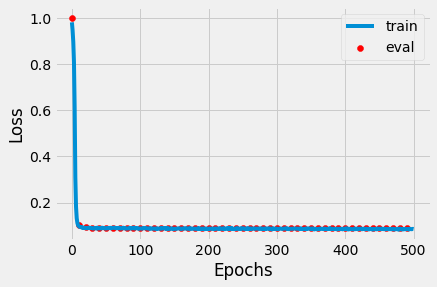

In [62]:
losses_arr = np.array(losses)
eval_losses_arr = np.array(eval_losses)

plt.style.use('fivethirtyeight')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
epoch = np.linspace(0,len(losses_arr), len(losses_arr))
t = np.linspace(0, len(losses_arr),len(losses_arr))
# Plotting the last 100 values
plt.plot(epoch, losses_arr, label = "train")
plt.scatter(eval_losses_arr[:,0],eval_losses_arr[:,1], label = "eval", color = 'r')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


R2 of X vel decoding from neurons: 0.5321811687381632
R2 of X vel decoding from latents: 0.8226059662882901
R2 of X vel decoding from autoencoded neurons: 0.7905409327168054

R2 of Y vel decoding from neurons: 0.48292891758437684
R2 of Y vel decoding from latents: 0.5701435630076784
R2 of Y vel decoding from autoencoded neurons: 0.5545456654020469



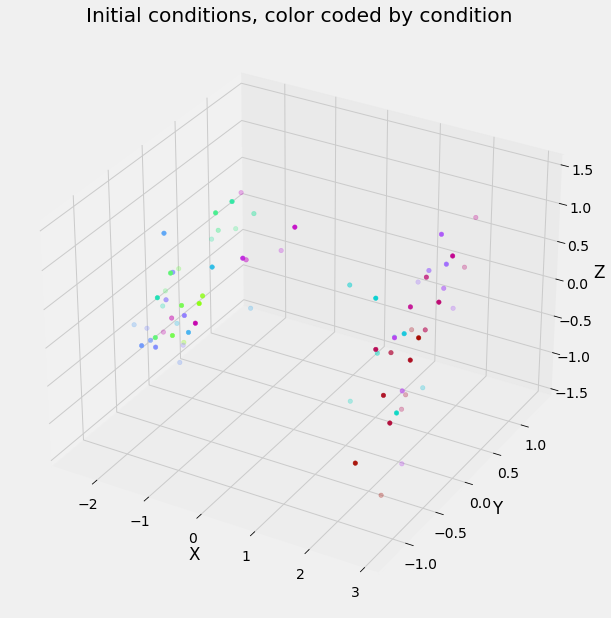

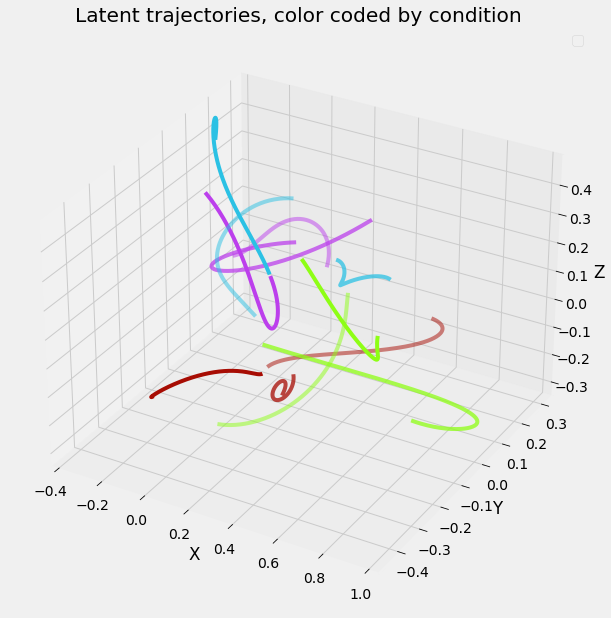

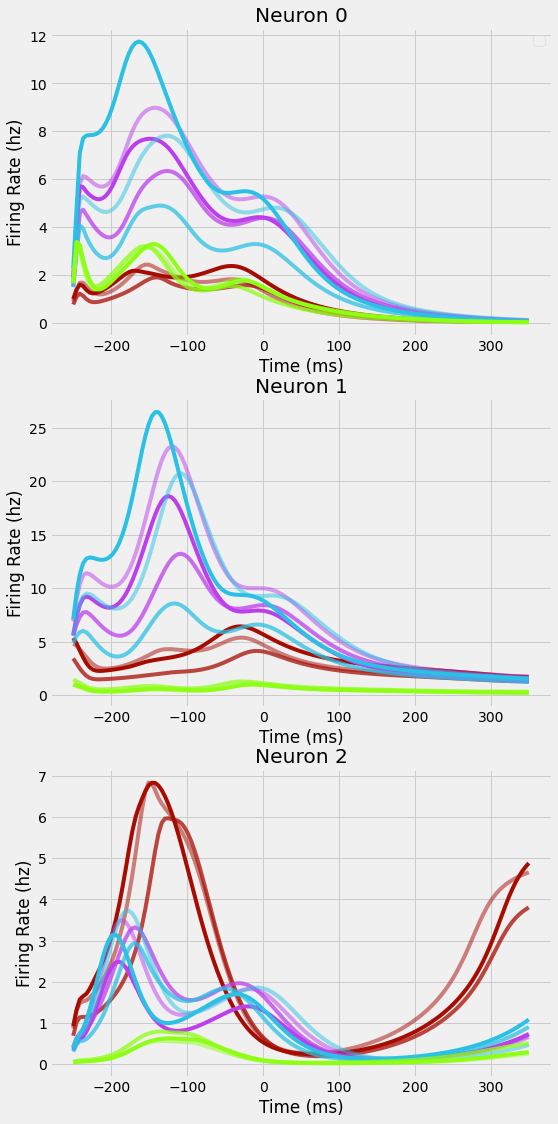

In [99]:
input_data, recon_target, vel, conds = ds_tensor_train 

recon_data, latents = sae(input_data)
_, ics = sae.encoder(input_data)
ics = torch.cat([*ics], -1)
ic_linear = sae.ic_linear(ics)
recon_data_plot = recon_data.detach().numpy()

ics_numpy = ics.detach().numpy()

conds_arr =  conds[:,0]
conds_to_plot = [3,4,5,6]
cond_avg = False

plot_ics(ics_numpy=ics_numpy, cond_arr = conds_arr)
plot_cond_avg_latent_traj(latents_plot=latents_plot, conds_trial=conds_arr, conds_to_plot= conds_to_plot, kernel_size=kernel_size, cond_avg= cond_avg)
computeHandVelR2Tensor(sae, ds_tensor_train=ds_tensor_train, kernel_size_in=20)

cond_avg = False
units_to_plot = [0,1,2]
plot_cond_avg_pred_fr(pred_rates= recon_data_plot, conds_trial = conds_arr, conds_to_plot = conds_to_plot,
                      units_to_plot = units_to_plot, kernel_size = kernel_size, cond_avg = cond_avg)



## But these models can be even better!

Unfortunately, real neural data can be quite messy, and there are a few additional tricks to get the dynamics models to fit well.

So that you can get a sense of how well a "good" model performs, check out the code below!

This was a model trained with a specialized training procedure called "coordinated dropout" for 10,000 epochs.



In [58]:
!wget -O pretrained_rnn.ckpt https://github.com/neurallatents/nlb_workshop/blob/main/nlb_technical/pretrained_rnn.ckpt?raw=true

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [59]:
from nlb_tools.make_tensors import make_train_input_tensors, make_eval_input_tensors

curr_path = os.getcwd()
fpath = "../../data/000138/sub-Jenkins/"
os.listdir(fpath) 

dataset_large = NWBDataset(fpath=fpath) 
dataset_large.resample(5)

train_dict = make_train_input_tensors(dataset=dataset_large, 
                                      dataset_name='mc_maze_large', 
                                      trial_split='train', # trial_split=['train', 'val'], for Test phase
                                      save_file=False, 
                                      include_forward_pred=True)

eval_dict = make_eval_input_tensors(dataset=dataset_large,
                                    dataset_name='mc_maze_large',
                                    trial_split='val', # trial_split='test', for Test phase
                                    save_file=False)

class NLBRNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(NLBRNN, self).__init__()
        self.dropout1 = torch.nn.Dropout(p=dropout)
        self.rnn = torch.nn.GRU(input_size=input_dim,
                                hidden_size=hidden_dim,
                                num_layers=num_layers,
                                batch_first=True,
                                dropout=(dropout if num_layers > 1 else 0.),
                                bidirectional=False,
                                **factory_kwargs)
        self.dropout2 = torch.nn.Dropout(p=dropout)
        self.transform = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, X):
        output, hidden = self.rnn(self.dropout1(X))
        output = self.transform(self.dropout2(output))
        return torch.exp(output), hidden

training_input = torch.Tensor(
    np.concatenate([
        train_dict['train_spikes_heldin'], 
        np.zeros(train_dict['train_spikes_heldin_forward'].shape), # zeroed inputs for forecasting
    ], axis=1))

training_output = torch.Tensor(
    np.concatenate([
        np.concatenate([
            train_dict['train_spikes_heldin'],
            train_dict['train_spikes_heldin_forward'],
        ], axis=1),
        np.concatenate([
            train_dict['train_spikes_heldout'],
            train_dict['train_spikes_heldout_forward'],
        ], axis=1),
    ], axis=2))

eval_input = torch.Tensor(
    np.concatenate([
        eval_dict['eval_spikes_heldin'],
        np.zeros((
            eval_dict['eval_spikes_heldin'].shape[0],
            train_dict['train_spikes_heldin_forward'].shape[1],
            eval_dict['eval_spikes_heldin'].shape[2]
        )),
    ], axis=1))

model = NLBRNN(input_dim=training_input.shape[2], hidden_dim=40, output_dim=training_output.shape[2])
ckpt = torch.load('pretrained_rnn.ckpt')
model.load_state_dict(ckpt['state_dict'])

model.eval()
training_predictions_torch, latents_train_torch = model(training_input)
training_predictions = training_predictions_torch.cpu().detach().numpy()
latents_train = latents_train_torch.cpu().detach().numpy()

eval_predictions_torch, latents_val_torch  = model(eval_input)
eval_predictions = eval_predictions_torch.cpu().detach().numpy()
latent_val = latents_val_torch.cpu().detach().numpy()

tlen = train_dict['train_spikes_heldin'].shape[1]
num_heldin = train_dict['train_spikes_heldin'].shape[2]

print(latents_train.shape)

submission = {
    'mc_maze_large': {
        'train_rates_heldin': training_predictions[:, :tlen, :num_heldin],
        'train_rates_heldout': training_predictions[:, :tlen, num_heldin:],
        'eval_rates_heldin': eval_predictions[:, :tlen, :num_heldin],
        'eval_rates_heldout': eval_predictions[:, :tlen, num_heldin:],
        'eval_rates_heldin_forward': eval_predictions[:, tlen:, :num_heldin],
        'eval_rates_heldout_forward': eval_predictions[:, tlen:, num_heldin:]
    }
}

c:\Users\Chris\miniconda3\envs\chenEnv3\lib\site-packages\hdmf\utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


(1, 375, 40)


In [60]:
from nlb_tools.evaluation import evaluate
from nlb_tools.make_tensors import make_eval_target_tensors

target_dict = make_eval_target_tensors(dataset=dataset_large, 
                                       dataset_name='mc_maze_large',
                                       train_trial_split='train',
                                       eval_trial_split='val',
                                       include_psth=True,
                                       save_file=False)

evaluate(target_dict, submission)

[{'mc_maze_scaling_split': {'[500] co-bps': 0.321185885778751,
   '[500] vel R2': 0.8568168372471365,
   '[500] psth R2': 0.574340439861282,
   '[500] fp-bps': 0.18072337733780505}}]

# Part 4: Future Directions

## Interpretability

## Neural Manifolds